In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 4
2023-07-29 11:18:24.953517


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-11.0065)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-2.3922)
penalty_target_min tensor(-11.0972) penalty_target_max tensor(10.5368)
train_loss:  -7.944463903427125
valid_loss:  -7.560206010437012
h_min_tilde -11.097233 ell_tilde -7.8676123248291026 kappa_tilde 0.0005564475747127613


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 3.9358038902282715

 2 5.394430160522461

 3 5.3933796882629395

 4 3.8472015857696533

 5 4.571310997009277

 6 3.841747283935547

 7 3.82908296585083

 8 4.25456428527832

 9 3.92130708694458

 10 5.055377006530762

 11 5.407852649688721

 12 3.7317583560943604

 13 3.598743438720703

 14 4.314544916152954

 15 3.7571041584014893

 16 3.67560076713562

 17 3.491708993911743

 18 6.564718723297119

 19 6.099911212921143

 20 4.412164688110352

 21 3.7444562911987305

 22 3.625153064727783

 23 3.834040641784668

 24 3.679678440093994

 25 4.376217842102051

 26 3.915010690689087

 27 3.9424476623535156

 28 3.9531707763671875

 29 3.9542462825775146

 30 3.8874881267547607

 31 4.0584001541137695

 32 4.138258457183838

 33 4.473786354064941

 34 4.362888813018799

 35 7.135592222213745

 36 6.090111970901489

 37 6.921826124191284

 38 6.634685277938843

 39 4.176600694656372

 40 3.6808226108551025

 41 3.8379907608032227

 42 3.783539295196533

 43 4.9427330493927

 44 3.508714

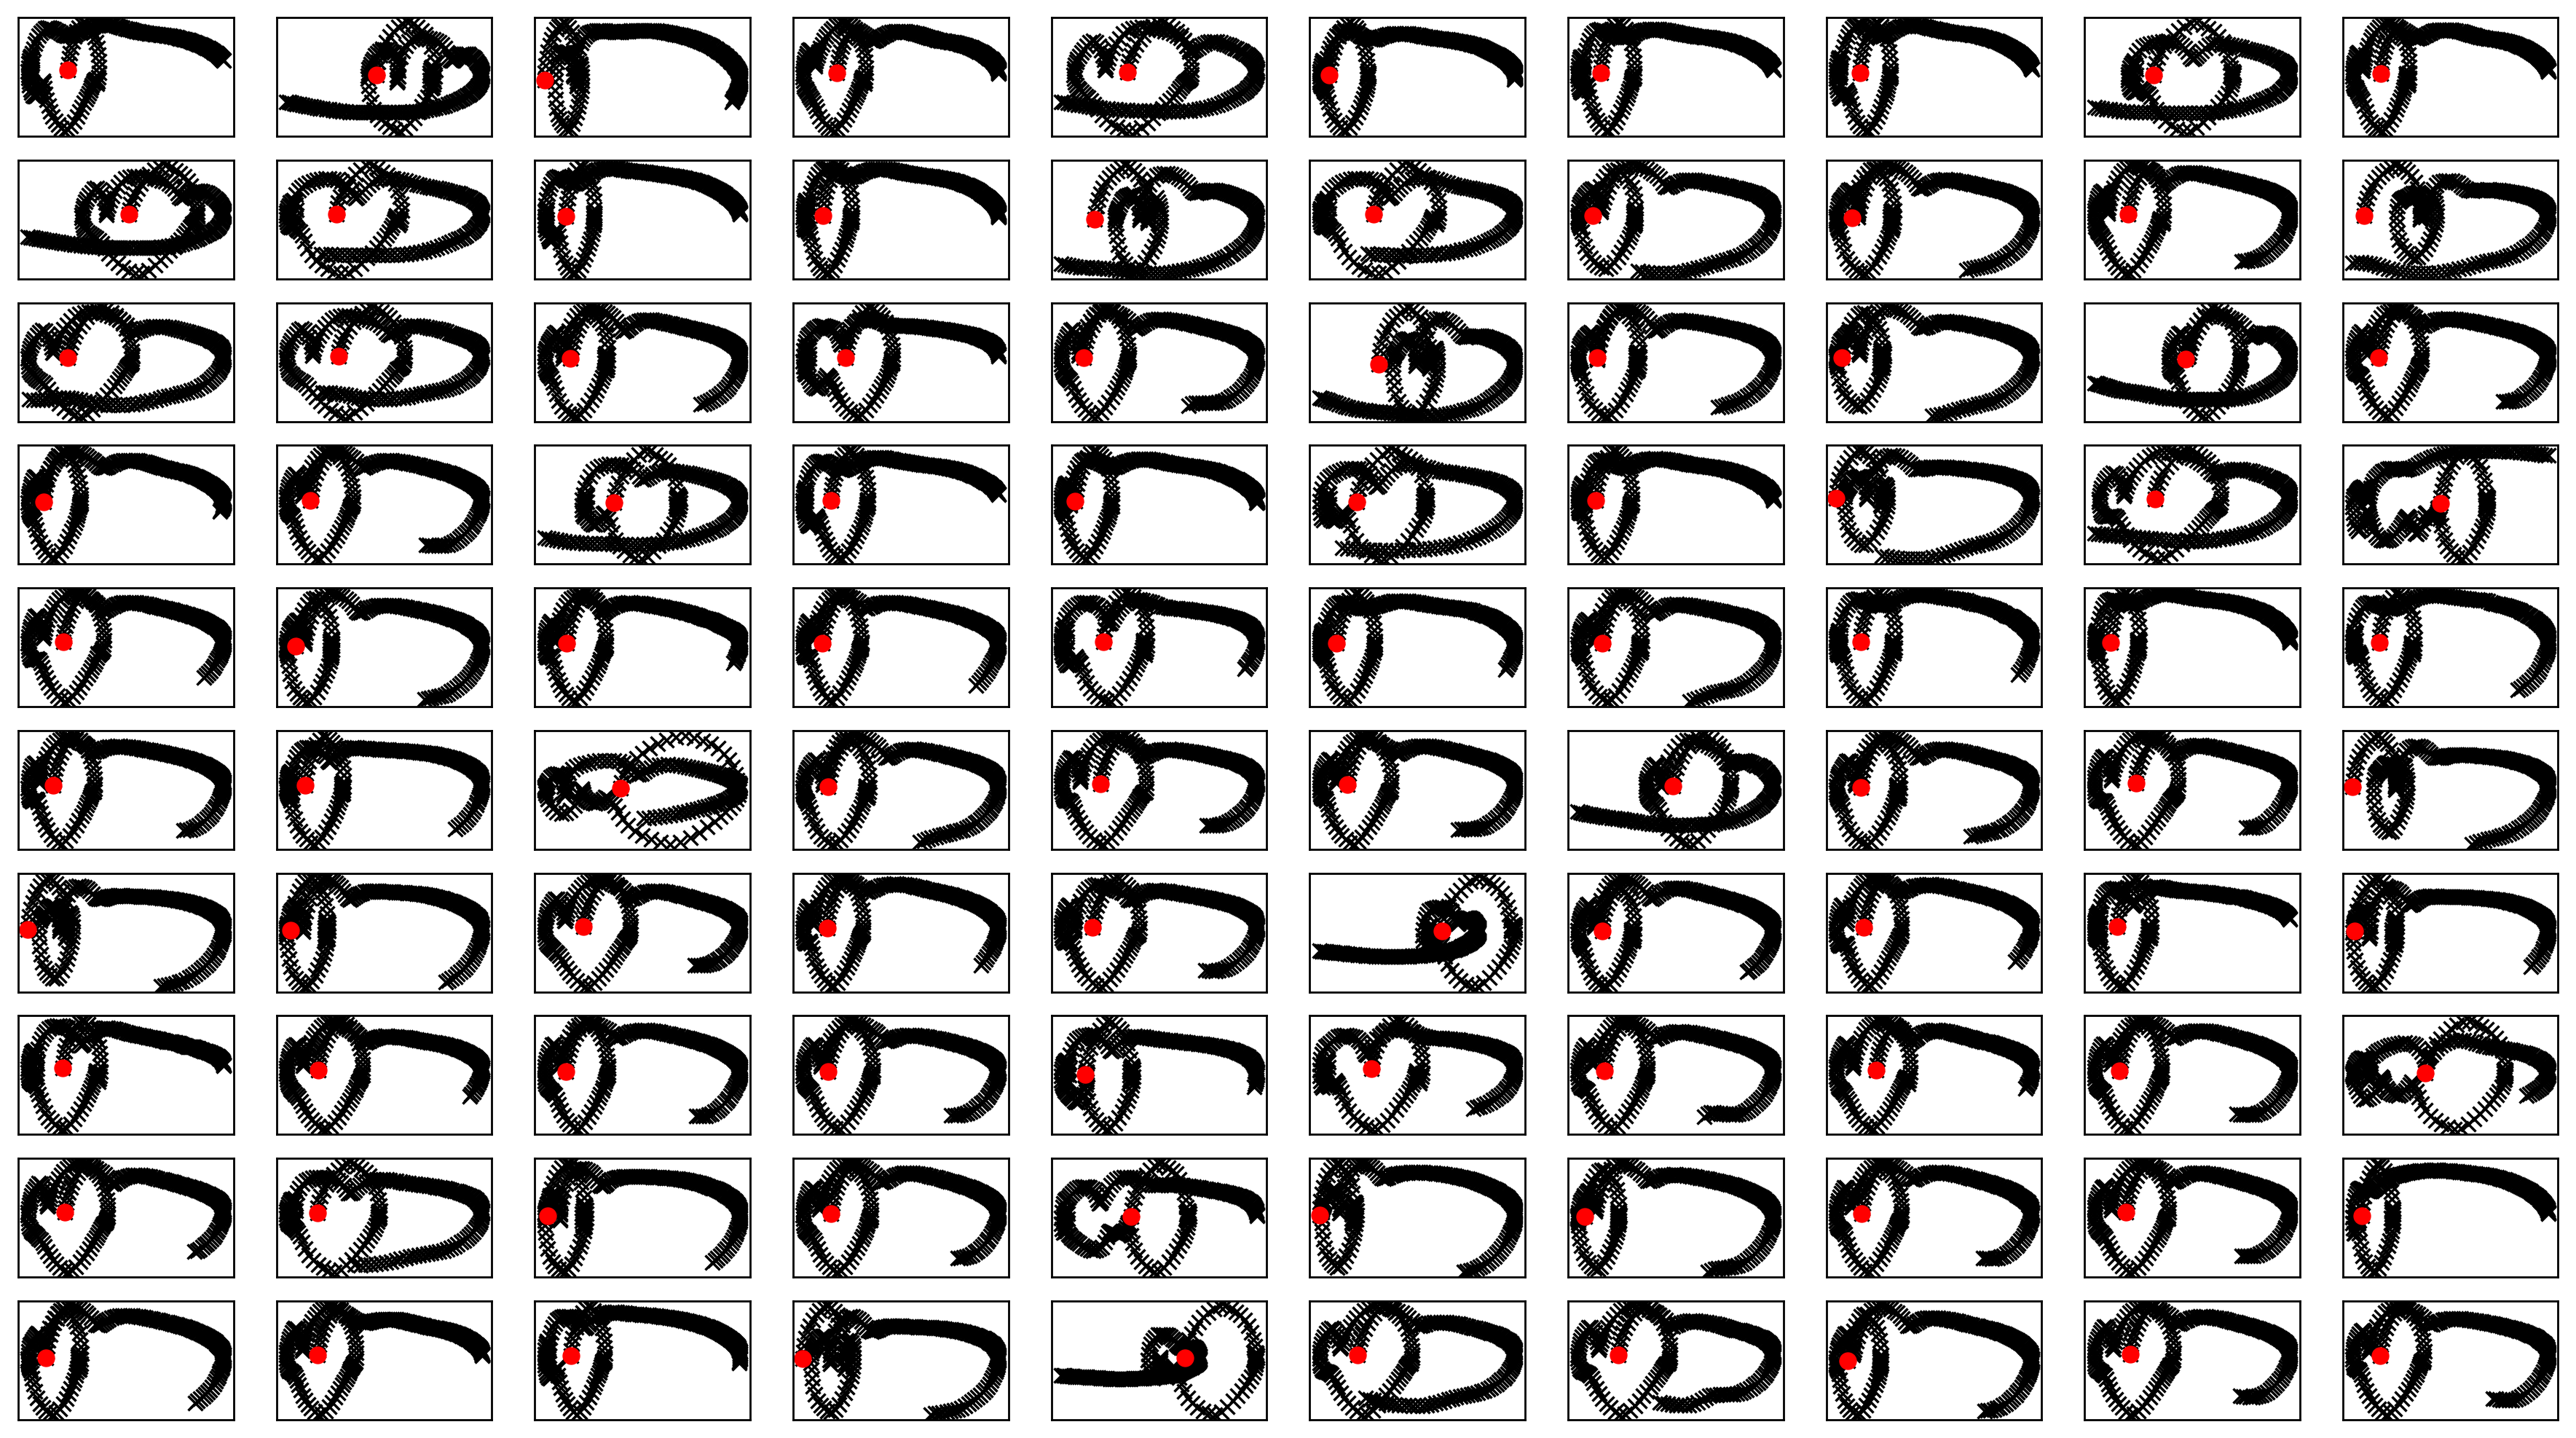

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

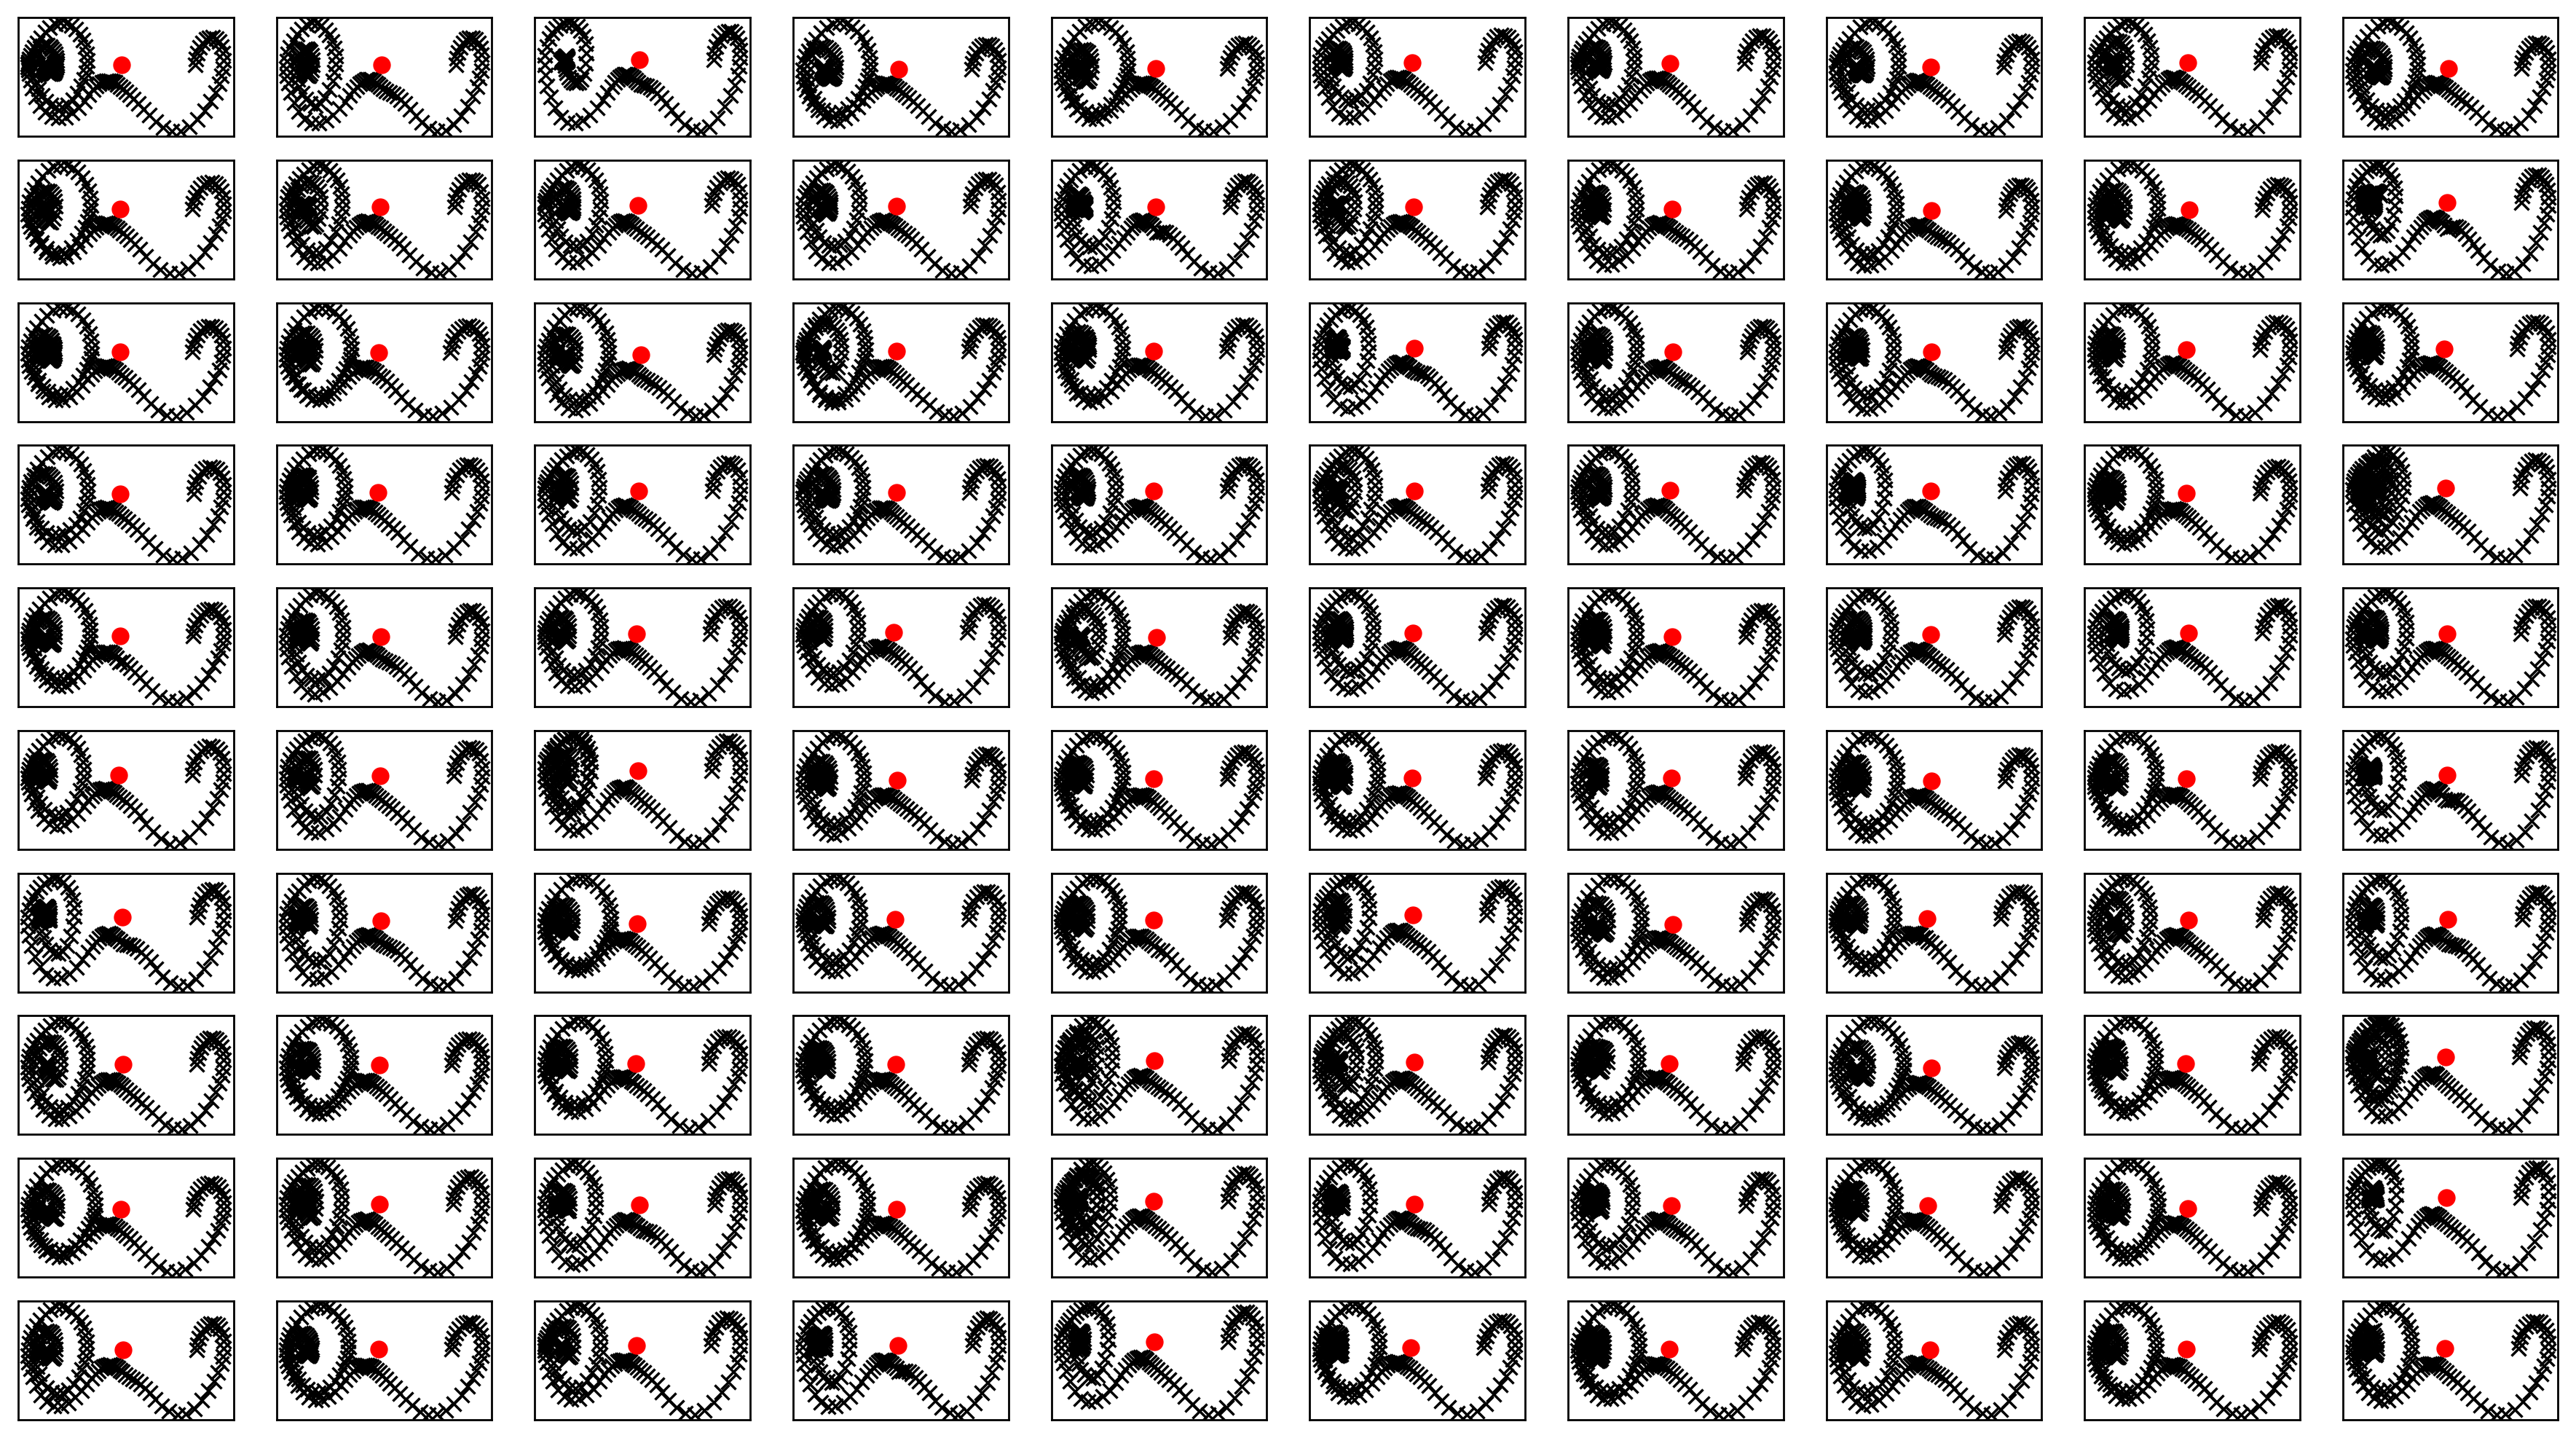

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-29 11:26:15.993821


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.35122  validloss 1.44622±0.00000  bestvalidloss 1.44622  last_update 0
train: iter 1  trainloss 1.23663  validloss 1.30680±0.00000  bestvalidloss 1.30680  last_update 0
train: iter 2  trainloss 1.14097  validloss 1.25850±0.00000  bestvalidloss 1.25850  last_update 0
train: iter 3  trainloss 1.07548  validloss 1.20705±0.00000  bestvalidloss 1.20705  last_update 0
train: iter 4  trainloss 1.02796  validloss 1.13377±0.00000  bestvalidloss 1.13377  last_update 0
train: iter 5  trainloss 0.98574  validloss 1.06383±0.00000  bestvalidloss 1.06383  last_update 0
train: iter 6  trainloss 0.95489  validloss 1.02505±0.00000  bestvalidloss 1.02505  last_update 0
train: iter 7  trainloss 0.92073  validloss 0.95664±0.00000  bestvalidloss 0.95664  last_update 0
train: iter 8  trainloss 0.88559  validloss 0.90289±0.00000  bestvalidloss 0.90289  last_update 0
train: iter 9  trainloss 0.86157  validloss 0.86089±0.00000  bestvalidloss 0.86089  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.51896  validloss 0.62642±0.00000  bestvalidloss 0.59831  last_update 3
train: iter 84  trainloss 0.52174  validloss 0.59985±0.00000  bestvalidloss 0.59831  last_update 4
train: iter 85  trainloss 0.51999  validloss 0.59333±0.00000  bestvalidloss 0.59333  last_update 0
train: iter 86  trainloss 0.51498  validloss 0.59625±0.00000  bestvalidloss 0.59333  last_update 1
train: iter 87  trainloss 0.51191  validloss 0.59223±0.00000  bestvalidloss 0.59223  last_update 0
train: iter 88  trainloss 0.51540  validloss 0.59663±0.00000  bestvalidloss 0.59223  last_update 1
train: iter 89  trainloss 0.50895  validloss 0.59149±0.00000  bestvalidloss 0.59149  last_update 0
train: iter 90  trainloss 0.50795  validloss 0.59963±0.00000  bestvalidloss 0.59149  last_update 1
train: iter 91  trainloss 0.51071  validloss 0.59961±0.00000  bestvalidloss 0.59149  last_update 2
train: iter 92  trainloss 0.51201  validloss 0.61568±0.00000  bestvalidloss 0.59149  last_update 3
train: ite

train: iter 166  trainloss 0.47643  validloss 0.54948±0.00000  bestvalidloss 0.54897  last_update 3
train: iter 167  trainloss 0.46482  validloss 0.56816±0.00000  bestvalidloss 0.54897  last_update 4
train: iter 168  trainloss 0.46788  validloss 0.57494±0.00000  bestvalidloss 0.54897  last_update 5
train: iter 169  trainloss 0.46556  validloss 0.56194±0.00000  bestvalidloss 0.54897  last_update 6
train: iter 170  trainloss 0.46879  validloss 0.57083±0.00000  bestvalidloss 0.54897  last_update 7
train: iter 171  trainloss 0.46814  validloss 0.56228±0.00000  bestvalidloss 0.54897  last_update 8
train: iter 172  trainloss 0.46725  validloss 0.57466±0.00000  bestvalidloss 0.54897  last_update 9
train: iter 173  trainloss 0.46714  validloss 0.55600±0.00000  bestvalidloss 0.54897  last_update 10
train: iter 174  trainloss 0.46243  validloss 0.56259±0.00000  bestvalidloss 0.54897  last_update 11
train: iter 175  trainloss 0.46286  validloss 0.55793±0.00000  bestvalidloss 0.54897  last_update 

train: iter 248  trainloss 0.44098  validloss 0.55969±0.00000  bestvalidloss 0.54897  last_update 85
train: iter 249  trainloss 0.44194  validloss 0.55807±0.00000  bestvalidloss 0.54897  last_update 86
train: iter 250  trainloss 0.44377  validloss 0.55891±0.00000  bestvalidloss 0.54897  last_update 87
train: iter 251  trainloss 0.44536  validloss 0.56477±0.00000  bestvalidloss 0.54897  last_update 88
train: iter 252  trainloss 0.44364  validloss 0.56476±0.00000  bestvalidloss 0.54897  last_update 89
train: iter 253  trainloss 0.44055  validloss 0.56391±0.00000  bestvalidloss 0.54897  last_update 90
train: iter 254  trainloss 0.45260  validloss 0.56562±0.00000  bestvalidloss 0.54897  last_update 91
train: iter 255  trainloss 0.43819  validloss 0.57012±0.00000  bestvalidloss 0.54897  last_update 92
train: iter 256  trainloss 0.43748  validloss 0.56093±0.00000  bestvalidloss 0.54897  last_update 93
train: iter 257  trainloss 0.44127  validloss 0.57126±0.00000  bestvalidloss 0.54897  last_

train_loss:  -7.408542515701055
valid_loss:  -7.26059827516079
weight_alpha 1.0 h_min_tilde -11.097233 ell_tilde -7.378953667593001 kappa_tilde 0.0005185958108475393
train_loss:  -4.9036229278564445
valid_loss:  -4.6415241512298575
weight_alpha 0.1 h_min_tilde -11.097233 ell_tilde -4.851203172531127 kappa_tilde 0.0004001271118903941


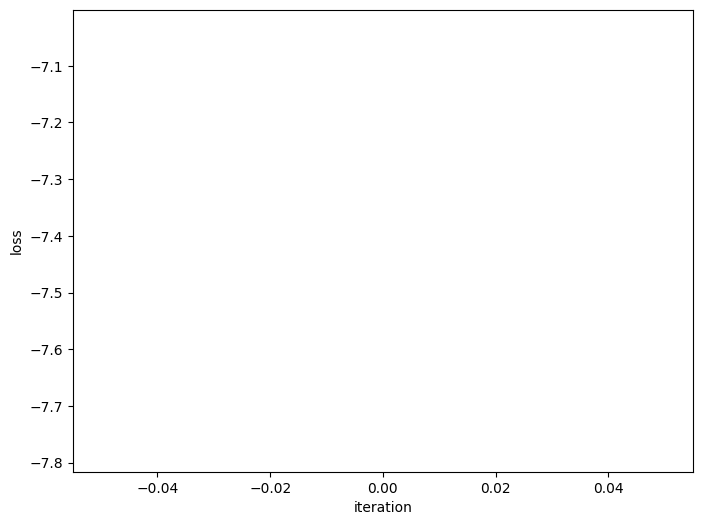

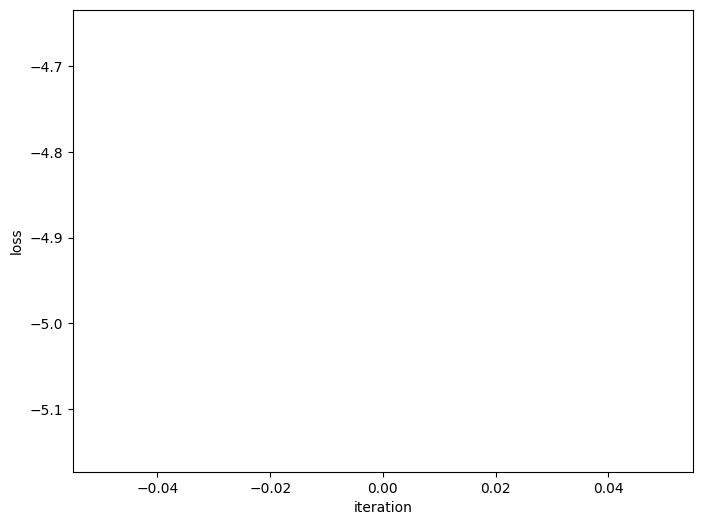

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -956.21022  validloss -927.92618±0.00000  bestvalidloss -927.92618  last_update 0
train: iter 1  trainloss -969.11577  validloss -913.04404±0.00000  bestvalidloss -927.92618  last_update 1
train: iter 2  trainloss -959.71370  validloss -888.36188±0.00000  bestvalidloss -927.92618  last_update 2
train: iter 3  trainloss -966.20735  validloss -877.23816±0.00000  bestvalidloss -927.92618  last_update 3
train: iter 4  trainloss -966.62531  validloss -908.01815±0.00000  bestvalidloss -927.92618  last_update 4
train: iter 5  trainloss -963.86500  validloss -843.96342±0.00000  bestvalidloss -927.92618  last_update 5
train: iter 6  trainloss -947.83468  validloss -850.18997±0.00000  bestvalidloss -927.92618  last_update 6
train: iter 7  trainloss -971.20749  validloss -899.82825±0.00000  bestvalidloss -927.92618  last_update 7
train: iter 8  trainloss -976.12536  validloss -914.93541±0.00000  bestvalidloss -927.92618  last_u

train: iter 76  trainloss -1006.38511  validloss -938.85567±0.00000  bestvalidloss -954.87770  last_update 12
train: iter 77  trainloss -990.33199  validloss -936.98793±0.00000  bestvalidloss -954.87770  last_update 13
train: iter 78  trainloss -1009.29487  validloss -963.59883±0.00000  bestvalidloss -963.59883  last_update 0
train: iter 79  trainloss -1006.86842  validloss -947.04008±0.00000  bestvalidloss -963.59883  last_update 1
train: iter 80  trainloss -978.56167  validloss -941.08689±0.00000  bestvalidloss -963.59883  last_update 2
train: iter 81  trainloss -998.25951  validloss -910.26205±0.00000  bestvalidloss -963.59883  last_update 3
train: iter 82  trainloss -1007.08522  validloss -955.00785±0.00000  bestvalidloss -963.59883  last_update 4
train: iter 83  trainloss -1004.26380  validloss -935.50739±0.00000  bestvalidloss -963.59883  last_update 5
train: iter 84  trainloss -1002.52696  validloss -947.13455±0.00000  bestvalidloss -963.59883  last_update 6
train: iter 85  trai

train: iter 151  trainloss -1017.78723  validloss -961.84187±0.00000  bestvalidloss -987.96114  last_update 4
train: iter 152  trainloss -1021.25792  validloss -924.25056±0.00000  bestvalidloss -987.96114  last_update 5
train: iter 153  trainloss -1015.40570  validloss -909.22055±0.00000  bestvalidloss -987.96114  last_update 6
train: iter 154  trainloss -1026.02041  validloss -985.57223±0.00000  bestvalidloss -987.96114  last_update 7
train: iter 155  trainloss -1020.24147  validloss -937.85748±0.00000  bestvalidloss -987.96114  last_update 8
train: iter 156  trainloss -1022.88874  validloss -978.35682±0.00000  bestvalidloss -987.96114  last_update 9
train: iter 157  trainloss -1014.85364  validloss -949.65809±0.00000  bestvalidloss -987.96114  last_update 10
train: iter 158  trainloss -910.89386  validloss -916.27288±0.00000  bestvalidloss -987.96114  last_update 11
train: iter 159  trainloss -1003.89074  validloss -914.64609±0.00000  bestvalidloss -987.96114  last_update 12
train: i

train: iter 226  trainloss -1033.56837  validloss -998.84067±0.00000  bestvalidloss -1005.80849  last_update 6
train: iter 227  trainloss -1016.28408  validloss -981.03699±0.00000  bestvalidloss -1005.80849  last_update 7
train: iter 228  trainloss -1021.56606  validloss -987.69698±0.00000  bestvalidloss -1005.80849  last_update 8
train: iter 229  trainloss -1026.82516  validloss -1003.79710±0.00000  bestvalidloss -1005.80849  last_update 9
train: iter 230  trainloss -1016.64690  validloss -939.99820±0.00000  bestvalidloss -1005.80849  last_update 10
train: iter 231  trainloss -1038.13845  validloss -967.66590±0.00000  bestvalidloss -1005.80849  last_update 11
train: iter 232  trainloss -1042.36840  validloss -1007.72591±0.00000  bestvalidloss -1007.72591  last_update 0
train: iter 233  trainloss -1044.05154  validloss -971.94614±0.00000  bestvalidloss -1007.72591  last_update 1
train: iter 234  trainloss -1033.28160  validloss -995.04670±0.00000  bestvalidloss -1007.72591  last_update

train: iter 300  trainloss -1045.68126  validloss -985.84419±0.00000  bestvalidloss -1021.88427  last_update 1
train: iter 301  trainloss -1056.97138  validloss -1018.96147±0.00000  bestvalidloss -1021.88427  last_update 2
train: iter 302  trainloss -1028.48995  validloss -1019.78347±0.00000  bestvalidloss -1021.88427  last_update 3
train: iter 303  trainloss -1033.28539  validloss -948.52010±0.00000  bestvalidloss -1021.88427  last_update 4
train: iter 304  trainloss -1056.71206  validloss -1023.03190±0.00000  bestvalidloss -1023.03190  last_update 0
train: iter 305  trainloss -1038.81682  validloss -1000.92681±0.00000  bestvalidloss -1023.03190  last_update 1
train: iter 306  trainloss -1054.37810  validloss -1014.91166±0.00000  bestvalidloss -1023.03190  last_update 2
train: iter 307  trainloss -1036.44565  validloss -991.46744±0.00000  bestvalidloss -1023.03190  last_update 3
train: iter 308  trainloss -1048.41266  validloss -959.99471±0.00000  bestvalidloss -1023.03190  last_updat

train: iter 374  trainloss -1061.53371  validloss -1033.74624±0.00000  bestvalidloss -1042.82647  last_update 55
train: iter 375  trainloss -1047.57269  validloss -1031.92138±0.00000  bestvalidloss -1042.82647  last_update 56
train: iter 376  trainloss -1059.70634  validloss -1031.47143±0.00000  bestvalidloss -1042.82647  last_update 57
train: iter 377  trainloss -1064.04384  validloss -1011.57297±0.00000  bestvalidloss -1042.82647  last_update 58
train: iter 378  trainloss -1045.42389  validloss -1034.62189±0.00000  bestvalidloss -1042.82647  last_update 59
train: iter 379  trainloss -1061.30319  validloss -1042.25219±0.00000  bestvalidloss -1042.82647  last_update 60
train: iter 380  trainloss -1052.48672  validloss -992.67056±0.00000  bestvalidloss -1042.82647  last_update 61
train: iter 381  trainloss -1063.32540  validloss -1023.95219±0.00000  bestvalidloss -1042.82647  last_update 62
train: iter 382  trainloss -1059.46256  validloss -1029.16487±0.00000  bestvalidloss -1042.82647 

train: iter 447  trainloss -1062.39959  validloss -1041.02719±0.00000  bestvalidloss -1054.88174  last_update 3
train: iter 448  trainloss -1060.53548  validloss -1038.65713±0.00000  bestvalidloss -1054.88174  last_update 4
train: iter 449  trainloss -1048.23839  validloss -1024.52458±0.00000  bestvalidloss -1054.88174  last_update 5
train: iter 450  trainloss -1064.84747  validloss -971.27287±0.00000  bestvalidloss -1054.88174  last_update 6
train: iter 451  trainloss -1065.88135  validloss -1027.31581±0.00000  bestvalidloss -1054.88174  last_update 7
train: iter 452  trainloss -1059.79165  validloss -1044.87655±0.00000  bestvalidloss -1054.88174  last_update 8
train: iter 453  trainloss -1076.67319  validloss -1057.05730±0.00000  bestvalidloss -1057.05730  last_update 0
train: iter 454  trainloss -977.95973  validloss -943.66206±0.00000  bestvalidloss -1057.05730  last_update 1
train: iter 455  trainloss -1056.82188  validloss -999.37799±0.00000  bestvalidloss -1057.05730  last_updat

train: iter 521  trainloss -1074.18335  validloss -1048.29678±0.00000  bestvalidloss -1073.73364  last_update 9
train: iter 522  trainloss -1074.73490  validloss -1026.45381±0.00000  bestvalidloss -1073.73364  last_update 10
train: iter 523  trainloss -1039.39697  validloss -1037.68576±0.00000  bestvalidloss -1073.73364  last_update 11
train: iter 524  trainloss -1052.63356  validloss -1001.02483±0.00000  bestvalidloss -1073.73364  last_update 12
train: iter 525  trainloss -1076.36610  validloss -1030.63438±0.00000  bestvalidloss -1073.73364  last_update 13
train: iter 526  trainloss -1073.73459  validloss -1023.64161±0.00000  bestvalidloss -1073.73364  last_update 14
train: iter 527  trainloss -1080.29003  validloss -1046.42863±0.00000  bestvalidloss -1073.73364  last_update 15
train: iter 528  trainloss -1070.09965  validloss -1034.30025±0.00000  bestvalidloss -1073.73364  last_update 16
train: iter 529  trainloss -1080.41148  validloss -1069.71945±0.00000  bestvalidloss -1073.73364 

train: iter 594  trainloss -1086.09081  validloss -1060.43368±0.00000  bestvalidloss -1073.73364  last_update 82
train: iter 595  trainloss -1081.59071  validloss -1075.47850±0.00000  bestvalidloss -1075.47850  last_update 0
train: iter 596  trainloss -1040.62244  validloss -1053.38820±0.00000  bestvalidloss -1075.47850  last_update 1
train: iter 597  trainloss -1085.38628  validloss -1013.37130±0.00000  bestvalidloss -1075.47850  last_update 2
train: iter 598  trainloss -1063.83239  validloss -1039.82340±0.00000  bestvalidloss -1075.47850  last_update 3
train: iter 599  trainloss -1095.98707  validloss -1021.99013±0.00000  bestvalidloss -1075.47850  last_update 4
train: iter 600  trainloss -1025.03019  validloss -1073.22279±0.00000  bestvalidloss -1075.47850  last_update 5
train: iter 601  trainloss -1053.06673  validloss -1000.26342±0.00000  bestvalidloss -1075.47850  last_update 6
train: iter 602  trainloss -1087.07632  validloss -1047.13934±0.00000  bestvalidloss -1075.47850  last_

train: iter 668  trainloss -1109.90835  validloss -1070.85525±0.00000  bestvalidloss -1090.29490  last_update 12
train: iter 669  trainloss -1115.56274  validloss -1089.80107±0.00000  bestvalidloss -1090.29490  last_update 13
train: iter 670  trainloss -1115.69318  validloss -1063.69135±0.00000  bestvalidloss -1090.29490  last_update 14
train: iter 671  trainloss -1115.58795  validloss -1077.76339±0.00000  bestvalidloss -1090.29490  last_update 15
train: iter 672  trainloss -1089.19412  validloss -1071.40033±0.00000  bestvalidloss -1090.29490  last_update 16
train: iter 673  trainloss -1082.03304  validloss -977.81518±0.00000  bestvalidloss -1090.29490  last_update 17
train: iter 674  trainloss -1104.01829  validloss -1068.74149±0.00000  bestvalidloss -1090.29490  last_update 18
train: iter 675  trainloss -1115.27744  validloss -1091.96027±0.00000  bestvalidloss -1091.96027  last_update 0
train: iter 676  trainloss -1117.45205  validloss -1076.98178±0.00000  bestvalidloss -1091.96027  

train: iter 741  trainloss -1071.53405  validloss -957.85422±0.00000  bestvalidloss -1122.19582  last_update 5
train: iter 742  trainloss -1113.85730  validloss -1085.90027±0.00000  bestvalidloss -1122.19582  last_update 6
train: iter 743  trainloss -1116.27512  validloss -1077.54232±0.00000  bestvalidloss -1122.19582  last_update 7
train: iter 744  trainloss -1106.67767  validloss -989.98174±0.00000  bestvalidloss -1122.19582  last_update 8
train: iter 745  trainloss -1118.62352  validloss -1009.68866±0.00000  bestvalidloss -1122.19582  last_update 9
train: iter 746  trainloss -1111.46422  validloss -1096.24426±0.00000  bestvalidloss -1122.19582  last_update 10
train: iter 747  trainloss -1124.82349  validloss -1106.73318±0.00000  bestvalidloss -1122.19582  last_update 11
train: iter 748  trainloss -1119.55836  validloss -1102.54973±0.00000  bestvalidloss -1122.19582  last_update 12
train: iter 749  trainloss -1099.61900  validloss -1083.28533±0.00000  bestvalidloss -1122.19582  last_

train: iter 814  trainloss -1113.45695  validloss -1072.89087±0.00000  bestvalidloss -1122.19582  last_update 78
train: iter 815  trainloss -1121.36722  validloss -1078.34506±0.00000  bestvalidloss -1122.19582  last_update 79
train: iter 816  trainloss -1113.23426  validloss -1078.02364±0.00000  bestvalidloss -1122.19582  last_update 80
train: iter 817  trainloss -1125.45860  validloss -1078.71482±0.00000  bestvalidloss -1122.19582  last_update 81
train: iter 818  trainloss -1115.66347  validloss -1091.55933±0.00000  bestvalidloss -1122.19582  last_update 82
train: iter 819  trainloss -1121.16232  validloss -1100.65692±0.00000  bestvalidloss -1122.19582  last_update 83
train: iter 820  trainloss -1108.18721  validloss -1069.08857±0.00000  bestvalidloss -1122.19582  last_update 84
train: iter 821  trainloss -1132.41459  validloss -1078.69705±0.00000  bestvalidloss -1122.19582  last_update 85
train: iter 822  trainloss -1111.27300  validloss -1110.79821±0.00000  bestvalidloss -1122.19582

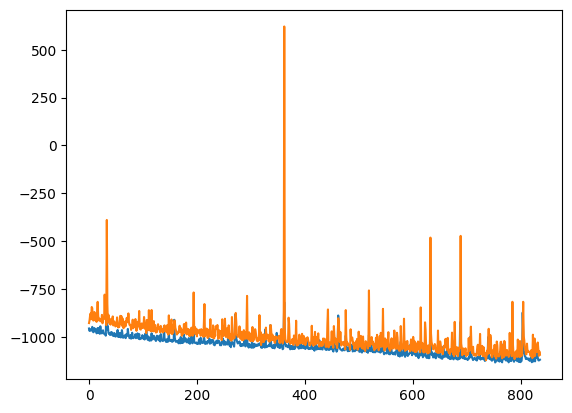

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-29 11:56:47.755780


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.53811  validloss 3.39957±0.00000  bestvalidloss 3.39957  last_update 0
train: iter 1  trainloss 0.76613  validloss 0.93491±0.00000  bestvalidloss 0.93491  last_update 0
train: iter 2  trainloss 0.69771  validloss 0.82539±0.00000  bestvalidloss 0.82539  last_update 0
train: iter 3  trainloss 0.67031  validloss 0.76468±0.00000  bestvalidloss 0.76468  last_update 0
train: iter 4  trainloss 0.64077  validloss 0.73228±0.00000  bestvalidloss 0.73228  last_update 0
train: iter 5  trainloss 0.61996  validloss 0.70814±0.00000  bestvalidloss 0.70814  last_update 0
train: iter 6  trainloss 0.61254  validloss 0.72264±0.00000  bestvalidloss 0.70814  last_update 1
train: iter 7  trainloss 0.61020  validloss 0.69720±0.00000  bestvalidloss 0.69720  last_update 0
train: iter 8  trainloss 0.59907  validloss 0.71260±0.00000  bestvalidloss 0.69720  last_update 1
train: iter 9  trainloss 0.59568  validloss 0.68023±0.00000  bestvalidloss 0.68023  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.50177  validloss 0.55244±0.00000  bestvalidloss 0.54013  last_update 5
train: iter 84  trainloss 0.50776  validloss 0.56473±0.00000  bestvalidloss 0.54013  last_update 6
train: iter 85  trainloss 0.50110  validloss 0.54933±0.00000  bestvalidloss 0.54013  last_update 7
train: iter 86  trainloss 0.50004  validloss 0.53980±0.00000  bestvalidloss 0.53980  last_update 0
train: iter 87  trainloss 0.51120  validloss 0.54844±0.00000  bestvalidloss 0.53980  last_update 1
train: iter 88  trainloss 0.50142  validloss 0.56154±0.00000  bestvalidloss 0.53980  last_update 2
train: iter 89  trainloss 0.50045  validloss 0.57198±0.00000  bestvalidloss 0.53980  last_update 3
train: iter 90  trainloss 0.51030  validloss 0.55234±0.00000  bestvalidloss 0.53980  last_update 4
train: iter 91  trainloss 0.50114  validloss 0.54276±0.00000  bestvalidloss 0.53980  last_update 5
train: iter 92  trainloss 0.50186  validloss 0.54329±0.00000  bestvalidloss 0.53980  last_update 6
train: ite

train: iter 165  trainloss 0.47604  validloss 0.51615±0.00000  bestvalidloss 0.51269  last_update 1
train: iter 166  trainloss 0.47307  validloss 0.51776±0.00000  bestvalidloss 0.51269  last_update 2
train: iter 167  trainloss 0.47002  validloss 0.53577±0.00000  bestvalidloss 0.51269  last_update 3
train: iter 168  trainloss 0.46705  validloss 0.52346±0.00000  bestvalidloss 0.51269  last_update 4
train: iter 169  trainloss 0.47033  validloss 0.55370±0.00000  bestvalidloss 0.51269  last_update 5
train: iter 170  trainloss 0.46828  validloss 0.53523±0.00000  bestvalidloss 0.51269  last_update 6
train: iter 171  trainloss 0.47046  validloss 0.51562±0.00000  bestvalidloss 0.51269  last_update 7
train: iter 172  trainloss 0.46226  validloss 0.50548±0.00000  bestvalidloss 0.50548  last_update 0
train: iter 173  trainloss 0.47470  validloss 0.52181±0.00000  bestvalidloss 0.50548  last_update 1
train: iter 174  trainloss 0.47018  validloss 0.51856±0.00000  bestvalidloss 0.50548  last_update 2


train: iter 247  trainloss 0.45002  validloss 0.49814±0.00000  bestvalidloss 0.48924  last_update 2
train: iter 248  trainloss 0.44959  validloss 0.51572±0.00000  bestvalidloss 0.48924  last_update 3
train: iter 249  trainloss 0.44903  validloss 0.50066±0.00000  bestvalidloss 0.48924  last_update 4
train: iter 250  trainloss 0.45368  validloss 0.48770±0.00000  bestvalidloss 0.48770  last_update 0
train: iter 251  trainloss 0.44845  validloss 0.49614±0.00000  bestvalidloss 0.48770  last_update 1
train: iter 252  trainloss 0.45462  validloss 0.52016±0.00000  bestvalidloss 0.48770  last_update 2
train: iter 253  trainloss 0.45001  validloss 0.49514±0.00000  bestvalidloss 0.48770  last_update 3
train: iter 254  trainloss 0.45077  validloss 0.50320±0.00000  bestvalidloss 0.48770  last_update 4
train: iter 255  trainloss 0.45490  validloss 0.53169±0.00000  bestvalidloss 0.48770  last_update 5
train: iter 256  trainloss 0.44037  validloss 0.49984±0.00000  bestvalidloss 0.48770  last_update 6


train: iter 329  trainloss 0.43924  validloss 0.47924±0.00000  bestvalidloss 0.46811  last_update 11
train: iter 330  trainloss 0.43010  validloss 0.47158±0.00000  bestvalidloss 0.46811  last_update 12
train: iter 331  trainloss 0.44643  validloss 0.48469±0.00000  bestvalidloss 0.46811  last_update 13
train: iter 332  trainloss 0.44056  validloss 0.50345±0.00000  bestvalidloss 0.46811  last_update 14
train: iter 333  trainloss 0.43081  validloss 0.47207±0.00000  bestvalidloss 0.46811  last_update 15
train: iter 334  trainloss 0.42788  validloss 0.49352±0.00000  bestvalidloss 0.46811  last_update 16
train: iter 335  trainloss 0.42637  validloss 0.46724±0.00000  bestvalidloss 0.46724  last_update 0
train: iter 336  trainloss 0.42766  validloss 0.48309±0.00000  bestvalidloss 0.46724  last_update 1
train: iter 337  trainloss 0.44278  validloss 0.47855±0.00000  bestvalidloss 0.46724  last_update 2
train: iter 338  trainloss 0.43427  validloss 0.47491±0.00000  bestvalidloss 0.46724  last_upd

train: iter 411  trainloss 0.41494  validloss 0.47691±0.00000  bestvalidloss 0.46343  last_update 34
train: iter 412  trainloss 0.41883  validloss 0.47825±0.00000  bestvalidloss 0.46343  last_update 35
train: iter 413  trainloss 0.42677  validloss 0.48080±0.00000  bestvalidloss 0.46343  last_update 36
train: iter 414  trainloss 0.42795  validloss 0.51274±0.00000  bestvalidloss 0.46343  last_update 37
train: iter 415  trainloss 0.41287  validloss 0.48227±0.00000  bestvalidloss 0.46343  last_update 38
train: iter 416  trainloss 0.42568  validloss 0.48559±0.00000  bestvalidloss 0.46343  last_update 39
train: iter 417  trainloss 0.43310  validloss 0.47917±0.00000  bestvalidloss 0.46343  last_update 40
train: iter 418  trainloss 0.42612  validloss 0.48904±0.00000  bestvalidloss 0.46343  last_update 41
train: iter 419  trainloss 0.41709  validloss 0.48084±0.00000  bestvalidloss 0.46343  last_update 42
train: iter 420  trainloss 0.41589  validloss 0.47859±0.00000  bestvalidloss 0.46343  last_

train: iter 493  trainloss 0.41510  validloss 0.51547±0.00000  bestvalidloss 0.45701  last_update 11
train: iter 494  trainloss 0.41065  validloss 0.48333±0.00000  bestvalidloss 0.45701  last_update 12
train: iter 495  trainloss 0.41404  validloss 0.46264±0.00000  bestvalidloss 0.45701  last_update 13
train: iter 496  trainloss 0.40624  validloss 0.46374±0.00000  bestvalidloss 0.45701  last_update 14
train: iter 497  trainloss 0.41699  validloss 0.49849±0.00000  bestvalidloss 0.45701  last_update 15
train: iter 498  trainloss 0.41069  validloss 0.46883±0.00000  bestvalidloss 0.45701  last_update 16
train: iter 499  trainloss 0.40991  validloss 0.48399±0.00000  bestvalidloss 0.45701  last_update 17
train: iter 500  trainloss 0.40854  validloss 0.47694±0.00000  bestvalidloss 0.45701  last_update 18
train: iter 501  trainloss 0.40410  validloss 0.48505±0.00000  bestvalidloss 0.45701  last_update 19
train: iter 502  trainloss 0.41214  validloss 0.46734±0.00000  bestvalidloss 0.45701  last_

train: iter 575  trainloss 0.40990  validloss 0.51492±0.00000  bestvalidloss 0.45573  last_update 51
train: iter 576  trainloss 0.41482  validloss 0.46058±0.00000  bestvalidloss 0.45573  last_update 52
train: iter 577  trainloss 0.40556  validloss 0.47091±0.00000  bestvalidloss 0.45573  last_update 53
train: iter 578  trainloss 0.39789  validloss 0.46160±0.00000  bestvalidloss 0.45573  last_update 54
train: iter 579  trainloss 0.40163  validloss 0.47578±0.00000  bestvalidloss 0.45573  last_update 55
train: iter 580  trainloss 0.39624  validloss 0.47333±0.00000  bestvalidloss 0.45573  last_update 56
train: iter 581  trainloss 0.40158  validloss 0.46988±0.00000  bestvalidloss 0.45573  last_update 57
train: iter 582  trainloss 0.39906  validloss 0.46439±0.00000  bestvalidloss 0.45573  last_update 58
train: iter 583  trainloss 0.40092  validloss 0.46164±0.00000  bestvalidloss 0.45573  last_update 59
train: iter 584  trainloss 0.39839  validloss 0.46343±0.00000  bestvalidloss 0.45573  last_

train: iter 657  trainloss 0.39077  validloss 0.45960±0.00000  bestvalidloss 0.45340  last_update 27
train: iter 658  trainloss 0.39878  validloss 0.48343±0.00000  bestvalidloss 0.45340  last_update 28
train: iter 659  trainloss 0.39612  validloss 0.45790±0.00000  bestvalidloss 0.45340  last_update 29
train: iter 660  trainloss 0.39412  validloss 0.46699±0.00000  bestvalidloss 0.45340  last_update 30
train: iter 661  trainloss 0.38875  validloss 0.45286±0.00000  bestvalidloss 0.45286  last_update 0
train: iter 662  trainloss 0.40104  validloss 0.50439±0.00000  bestvalidloss 0.45286  last_update 1
train: iter 663  trainloss 0.39138  validloss 0.45354±0.00000  bestvalidloss 0.45286  last_update 2
train: iter 664  trainloss 0.39386  validloss 0.47033±0.00000  bestvalidloss 0.45286  last_update 3
train: iter 665  trainloss 0.39464  validloss 0.48857±0.00000  bestvalidloss 0.45286  last_update 4
train: iter 666  trainloss 0.39073  validloss 0.46261±0.00000  bestvalidloss 0.45286  last_updat

train: iter 739  trainloss 0.38682  validloss 0.46290±0.00000  bestvalidloss 0.45286  last_update 78
train: iter 740  trainloss 0.38766  validloss 0.47612±0.00000  bestvalidloss 0.45286  last_update 79
train: iter 741  trainloss 0.38090  validloss 0.46286±0.00000  bestvalidloss 0.45286  last_update 80
train: iter 742  trainloss 0.38858  validloss 0.46567±0.00000  bestvalidloss 0.45286  last_update 81
train: iter 743  trainloss 0.39123  validloss 0.47042±0.00000  bestvalidloss 0.45286  last_update 82
train: iter 744  trainloss 0.38693  validloss 0.46378±0.00000  bestvalidloss 0.45286  last_update 83
train: iter 745  trainloss 0.38517  validloss 0.45834±0.00000  bestvalidloss 0.45286  last_update 84
train: iter 746  trainloss 0.38777  validloss 0.47430±0.00000  bestvalidloss 0.45286  last_update 85
train: iter 747  trainloss 0.38620  validloss 0.46622±0.00000  bestvalidloss 0.45286  last_update 86
train: iter 748  trainloss 0.38494  validloss 0.46922±0.00000  bestvalidloss 0.45286  last_

train_loss:  -4.840045001965761
valid_loss:  -5.924673175930977
weight_alpha 1.0 h_min_tilde -11.459714 ell_tilde -5.0569706367588045 kappa_tilde 0.00039520001723229985
train_loss:  -3.9499853436946863
valid_loss:  -3.6887380373001095
weight_alpha 0.1 h_min_tilde -11.459714 ell_tilde -3.897735882415771 kappa_tilde 0.00036364891296367753


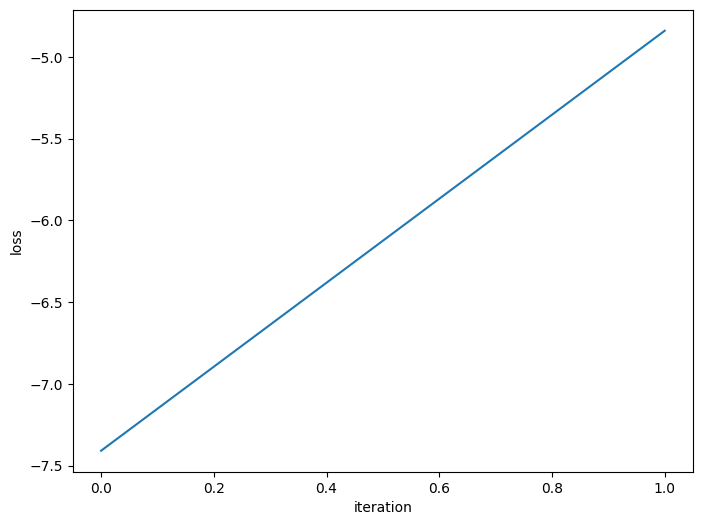

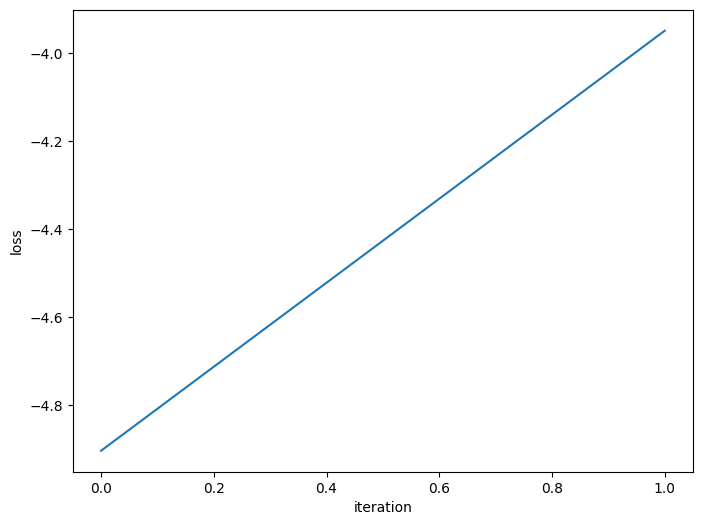

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -749.60289  validloss -738.78118±0.00000  bestvalidloss -738.78118  last_update 0
train: iter 1  trainloss -783.05544  validloss -714.26875±0.00000  bestvalidloss -738.78118  last_update 1
train: iter 2  trainloss -789.84869  validloss -765.18007±0.00000  bestvalidloss -765.18007  last_update 0
train: iter 3  trainloss -786.13918  validloss -748.82473±0.00000  bestvalidloss -765.18007  last_update 1
train: iter 4  trainloss -747.49836  validloss -722.61052±0.00000  bestvalidloss -765.18007  last_update 2
train: iter 5  trainloss -778.56223  validloss -751.68431±0.00000  bestvalidloss -765.18007  last_update 3
train: iter 6  trainloss -777.95056  validloss -728.44768±0.00000  bestvalidloss -765.18007  last_update 4
train: iter 7  trainloss -793.88206  validloss -754.70231±0.00000  bestvalidloss -765.18007  last_update 5
train: iter 8  trainloss -734.25983  validloss -725.50433±0.00000  bestvalidloss -765.18007  last_u

train: iter 76  trainloss -773.80107  validloss -654.07366±0.00000  bestvalidloss -772.63743  last_update 54
train: iter 77  trainloss -790.99682  validloss -757.31796±0.00000  bestvalidloss -772.63743  last_update 55
train: iter 78  trainloss -776.42259  validloss -683.35737±0.00000  bestvalidloss -772.63743  last_update 56
train: iter 79  trainloss -798.38832  validloss -748.55908±0.00000  bestvalidloss -772.63743  last_update 57
train: iter 80  trainloss -773.52150  validloss -713.78944±0.00000  bestvalidloss -772.63743  last_update 58
train: iter 81  trainloss -795.76571  validloss -708.89615±0.00000  bestvalidloss -772.63743  last_update 59
train: iter 82  trainloss -788.61793  validloss -743.25274±0.00000  bestvalidloss -772.63743  last_update 60
train: iter 83  trainloss -785.78172  validloss -730.69673±0.00000  bestvalidloss -772.63743  last_update 61
train: iter 84  trainloss -704.19334  validloss -741.45193±0.00000  bestvalidloss -772.63743  last_update 62
train: iter 85  tra

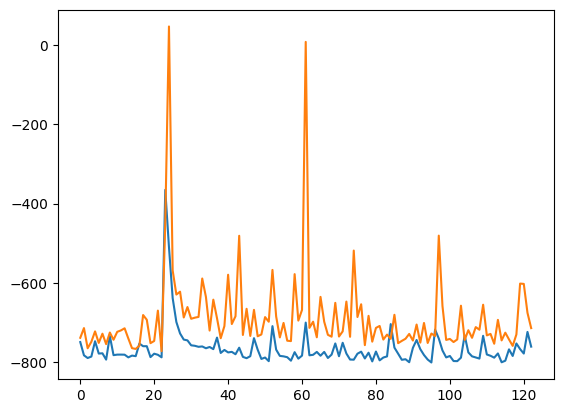

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-29 12:24:32.862744


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.52556  validloss 0.62586±0.00000  bestvalidloss 0.62586  last_update 0
train: iter 1  trainloss 0.52287  validloss 0.59599±0.00000  bestvalidloss 0.59599  last_update 0
train: iter 2  trainloss 0.50559  validloss 0.56218±0.00000  bestvalidloss 0.56218  last_update 0
train: iter 3  trainloss 0.50187  validloss 0.55514±0.00000  bestvalidloss 0.55514  last_update 0
train: iter 4  trainloss 0.49889  validloss 0.56160±0.00000  bestvalidloss 0.55514  last_update 1
train: iter 5  trainloss 0.50051  validloss 0.56047±0.00000  bestvalidloss 0.55514  last_update 2
train: iter 6  trainloss 0.49411  validloss 0.55249±0.00000  bestvalidloss 0.55249  last_update 0
train: iter 7  trainloss 0.48742  validloss 0.55465±0.00000  bestvalidloss 0.55249  last_update 1
train: iter 8  trainloss 0.48864  validloss 0.55536±0.00000  bestvalidloss 0.55249  last_update 2
train: iter 9  trainloss 0.48549  validloss 0.54711±0.00000  bestvalidloss 0.54711  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.42816  validloss 0.50819±0.00000  bestvalidloss 0.49506  last_update 19
train: iter 84  trainloss 0.43483  validloss 0.50627±0.00000  bestvalidloss 0.49506  last_update 20
train: iter 85  trainloss 0.43610  validloss 0.49829±0.00000  bestvalidloss 0.49506  last_update 21
train: iter 86  trainloss 0.43061  validloss 0.50960±0.00000  bestvalidloss 0.49506  last_update 22
train: iter 87  trainloss 0.43147  validloss 0.51308±0.00000  bestvalidloss 0.49506  last_update 23
train: iter 88  trainloss 0.43176  validloss 0.49014±0.00000  bestvalidloss 0.49014  last_update 0
train: iter 89  trainloss 0.43145  validloss 0.49706±0.00000  bestvalidloss 0.49014  last_update 1
train: iter 90  trainloss 0.43096  validloss 0.49104±0.00000  bestvalidloss 0.49014  last_update 2
train: iter 91  trainloss 0.43247  validloss 0.50445±0.00000  bestvalidloss 0.49014  last_update 3
train: iter 92  trainloss 0.43039  validloss 0.50398±0.00000  bestvalidloss 0.49014  last_update 4
train

train: iter 165  trainloss 0.41880  validloss 0.48963±0.00000  bestvalidloss 0.48963  last_update 0
train: iter 166  trainloss 0.41706  validloss 0.49491±0.00000  bestvalidloss 0.48963  last_update 1
train: iter 167  trainloss 0.42017  validloss 0.50773±0.00000  bestvalidloss 0.48963  last_update 2
train: iter 168  trainloss 0.41399  validloss 0.50065±0.00000  bestvalidloss 0.48963  last_update 3
train: iter 169  trainloss 0.41677  validloss 0.49965±0.00000  bestvalidloss 0.48963  last_update 4
train: iter 170  trainloss 0.41594  validloss 0.51720±0.00000  bestvalidloss 0.48963  last_update 5
train: iter 171  trainloss 0.41668  validloss 0.50317±0.00000  bestvalidloss 0.48963  last_update 6
train: iter 172  trainloss 0.41658  validloss 0.48933±0.00000  bestvalidloss 0.48933  last_update 0
train: iter 173  trainloss 0.41417  validloss 0.50101±0.00000  bestvalidloss 0.48933  last_update 1
train: iter 174  trainloss 0.41831  validloss 0.49012±0.00000  bestvalidloss 0.48933  last_update 2


train: iter 248  trainloss 0.40723  validloss 0.49118±0.00000  bestvalidloss 0.48896  last_update 14
train: iter 249  trainloss 0.40705  validloss 0.50249±0.00000  bestvalidloss 0.48896  last_update 15
train: iter 250  trainloss 0.41275  validloss 0.49808±0.00000  bestvalidloss 0.48896  last_update 16
train: iter 251  trainloss 0.40745  validloss 0.53777±0.00000  bestvalidloss 0.48896  last_update 17
train: iter 252  trainloss 0.40392  validloss 0.50077±0.00000  bestvalidloss 0.48896  last_update 18
train: iter 253  trainloss 0.40633  validloss 0.50304±0.00000  bestvalidloss 0.48896  last_update 19
train: iter 254  trainloss 0.40352  validloss 0.49590±0.00000  bestvalidloss 0.48896  last_update 20
train: iter 255  trainloss 0.40523  validloss 0.50652±0.00000  bestvalidloss 0.48896  last_update 21
train: iter 256  trainloss 0.41108  validloss 0.51176±0.00000  bestvalidloss 0.48896  last_update 22
train: iter 257  trainloss 0.40519  validloss 0.49950±0.00000  bestvalidloss 0.48896  last_

train: iter 330  trainloss 0.39661  validloss 0.49579±0.00000  bestvalidloss 0.48803  last_update 23
train: iter 331  trainloss 0.39789  validloss 0.50504±0.00000  bestvalidloss 0.48803  last_update 24
train: iter 332  trainloss 0.39766  validloss 0.50205±0.00000  bestvalidloss 0.48803  last_update 25
train: iter 333  trainloss 0.40121  validloss 0.50956±0.00000  bestvalidloss 0.48803  last_update 26
train: iter 334  trainloss 0.39662  validloss 0.49152±0.00000  bestvalidloss 0.48803  last_update 27
train: iter 335  trainloss 0.39556  validloss 0.50922±0.00000  bestvalidloss 0.48803  last_update 28
train: iter 336  trainloss 0.39575  validloss 0.49696±0.00000  bestvalidloss 0.48803  last_update 29
train: iter 337  trainloss 0.39540  validloss 0.49557±0.00000  bestvalidloss 0.48803  last_update 30
train: iter 338  trainloss 0.39563  validloss 0.50089±0.00000  bestvalidloss 0.48803  last_update 31
train: iter 339  trainloss 0.39753  validloss 0.50096±0.00000  bestvalidloss 0.48803  last_

train_loss:  -6.524855993127824
valid_loss:  -7.584470267629624
weight_alpha 1.0 h_min_tilde -11.459655 ell_tilde -6.736778848028184 kappa_tilde 0.0004601471433494558
train_loss:  -4.292493737792968
valid_loss:  -3.7853866945266716
weight_alpha 0.1 h_min_tilde -11.459655 ell_tilde -4.1910723291397085 kappa_tilde 0.00037091563352490906


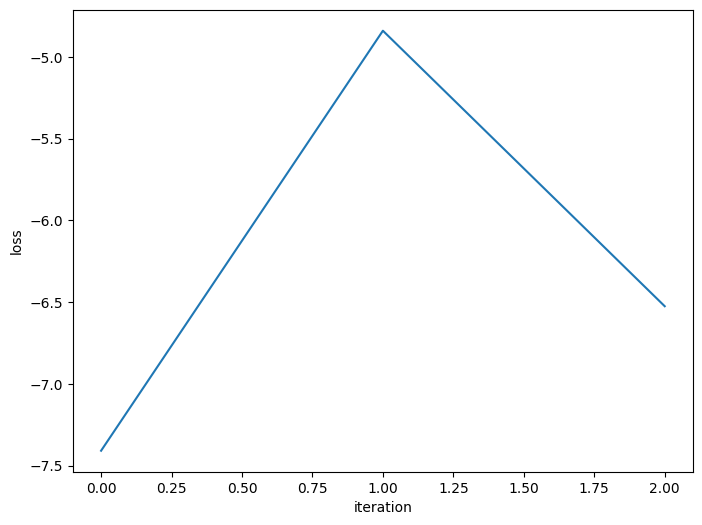

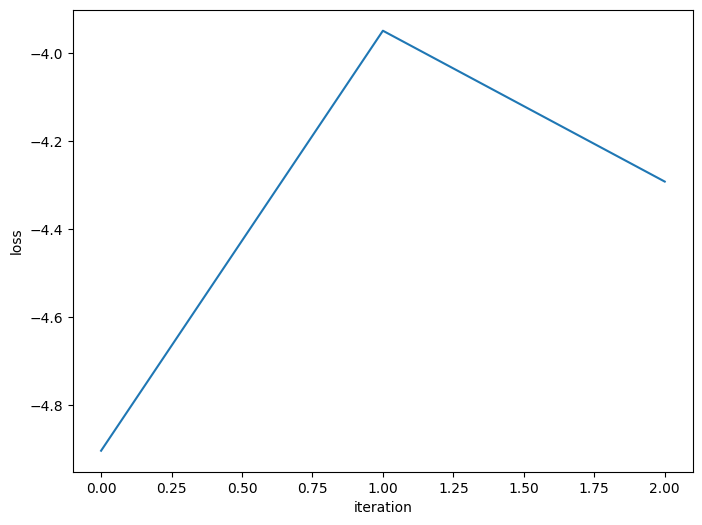

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -858.59469  validloss -757.35783±0.00000  bestvalidloss -757.35783  last_update 0
train: iter 1  trainloss -876.29720  validloss -843.92860±0.00000  bestvalidloss -843.92860  last_update 0
train: iter 2  trainloss -792.72258  validloss -823.86300±0.00000  bestvalidloss -843.92860  last_update 1
train: iter 3  trainloss -867.22119  validloss -797.65271±0.00000  bestvalidloss -843.92860  last_update 2
train: iter 4  trainloss -821.32730  validloss -842.91110±0.00000  bestvalidloss -843.92860  last_update 3
train: iter 5  trainloss -864.49376  validloss -776.26351±0.00000  bestvalidloss -843.92860  last_update 4
train: iter 6  trainloss -886.75964  validloss -805.87044±0.00000  bestvalidloss -843.92860  last_update 5
train: iter 7  trainloss -761.68373  validloss -845.26131±0.00000  bestvalidloss -845.26131  last_update 0
train: iter 8  trainloss -857.83332  validloss -704.15187±0.00000  bestvalidloss -845.26131  last_u

train: iter 76  trainloss -900.87037  validloss -884.52247±0.00000  bestvalidloss -884.52247  last_update 0
train: iter 77  trainloss -882.59830  validloss -880.05939±0.00000  bestvalidloss -884.52247  last_update 1
train: iter 78  trainloss -872.86127  validloss -781.31619±0.00000  bestvalidloss -884.52247  last_update 2
train: iter 79  trainloss -883.88016  validloss -682.21983±0.00000  bestvalidloss -884.52247  last_update 3
train: iter 80  trainloss -889.24077  validloss -867.86979±0.00000  bestvalidloss -884.52247  last_update 4
train: iter 81  trainloss -786.72984  validloss -875.11112±0.00000  bestvalidloss -884.52247  last_update 5
train: iter 82  trainloss -858.26888  validloss -711.17361±0.00000  bestvalidloss -884.52247  last_update 6
train: iter 83  trainloss -871.65222  validloss -857.47163±0.00000  bestvalidloss -884.52247  last_update 7
train: iter 84  trainloss -894.70799  validloss -871.53754±0.00000  bestvalidloss -884.52247  last_update 8
train: iter 85  trainloss -8

train: iter 152  trainloss -883.69940  validloss -822.41977±0.00000  bestvalidloss -884.52247  last_update 76
train: iter 153  trainloss -861.24556  validloss -844.01922±0.00000  bestvalidloss -884.52247  last_update 77
train: iter 154  trainloss -888.18142  validloss -856.38172±0.00000  bestvalidloss -884.52247  last_update 78
train: iter 155  trainloss -860.37269  validloss -868.86789±0.00000  bestvalidloss -884.52247  last_update 79
train: iter 156  trainloss -867.91029  validloss -767.08413±0.00000  bestvalidloss -884.52247  last_update 80
train: iter 157  trainloss -884.48747  validloss -838.81910±0.00000  bestvalidloss -884.52247  last_update 81
train: iter 158  trainloss -894.87160  validloss -820.94229±0.00000  bestvalidloss -884.52247  last_update 82
train: iter 159  trainloss -772.78076  validloss -832.74597±0.00000  bestvalidloss -884.52247  last_update 83
train: iter 160  trainloss -873.76883  validloss -820.23784±0.00000  bestvalidloss -884.52247  last_update 84
train: ite

train: iter 227  trainloss -671.09237  validloss -570.54280±0.00000  bestvalidloss -901.20940  last_update 8
train: iter 228  trainloss -802.51142  validloss -683.74995±0.00000  bestvalidloss -901.20940  last_update 9
train: iter 229  trainloss -823.97259  validloss -717.77752±0.00000  bestvalidloss -901.20940  last_update 10
train: iter 230  trainloss -826.40341  validloss -815.69912±0.00000  bestvalidloss -901.20940  last_update 11
train: iter 231  trainloss -859.15665  validloss -823.29373±0.00000  bestvalidloss -901.20940  last_update 12
train: iter 232  trainloss -872.79400  validloss -817.61388±0.00000  bestvalidloss -901.20940  last_update 13
train: iter 233  trainloss -883.19199  validloss -857.85137±0.00000  bestvalidloss -901.20940  last_update 14
train: iter 234  trainloss -843.81758  validloss -870.76829±0.00000  bestvalidloss -901.20940  last_update 15
train: iter 235  trainloss -860.41737  validloss -837.18774±0.00000  bestvalidloss -901.20940  last_update 16
train: iter 

train: iter 302  trainloss -900.59755  validloss -877.69953±0.00000  bestvalidloss -901.20940  last_update 83
train: iter 303  trainloss -896.26935  validloss -869.89347±0.00000  bestvalidloss -901.20940  last_update 84
train: iter 304  trainloss -879.54468  validloss -789.82776±0.00000  bestvalidloss -901.20940  last_update 85
train: iter 305  trainloss -884.78826  validloss -856.70144±0.00000  bestvalidloss -901.20940  last_update 86
train: iter 306  trainloss -885.01872  validloss -837.65200±0.00000  bestvalidloss -901.20940  last_update 87
train: iter 307  trainloss -893.27786  validloss -835.78009±0.00000  bestvalidloss -901.20940  last_update 88
train: iter 308  trainloss -890.28642  validloss -825.15752±0.00000  bestvalidloss -901.20940  last_update 89
train: iter 309  trainloss -884.42270  validloss -784.28168±0.00000  bestvalidloss -901.20940  last_update 90
train: iter 310  trainloss -868.49591  validloss -822.83736±0.00000  bestvalidloss -901.20940  last_update 91
train: ite

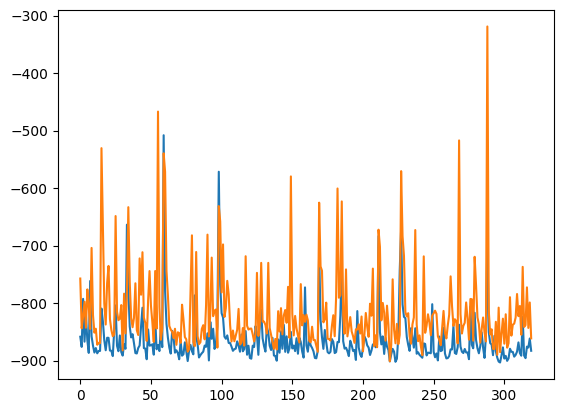

alpha 0.1 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-07-29 12:50:34.173064


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48
predict diverge [ 30.04769104  23.97285525  -8.76269003 -16.6857952 ] [ 0.92486794  0.83014463 -0.83216451 -0.61501826] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 95

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.56315  validloss 0.83504±0.00000  bestvalidloss 0.83504  last_update 0
train: iter 1  trainloss 0.50642  validloss 0.63616±0.00000  bestvalidloss 0.63616  last_update 0
train: iter 2  trainloss 0.49376  validloss 0.62110±0.00000  bestvalidloss 0.62110  last_update 0
train: iter 3  trainloss 0.49101  validloss 0.62746±0.00000  bestvalidloss 0.62110  last_update 1
train: iter 4  trainloss 0.48538  validloss 0.60402±0.00000  bestvalidloss 0.60402  last_update 0
train: iter 5  trainloss 0.48300  validloss 0.61457±0.00000  bestvalidloss 0.60402  last_update 1
train: iter 6  trainloss 0.48026  validloss 0.60270±0.00000  bestvalidloss 0.60270  last_update 0
train: iter 7  trainloss 0.47838  validloss 0.61174±0.00000  bestvalidloss 0.60270  last_update 1
train: iter 8  trainloss 0.47402  validloss 0.61054±0.00000  bestvalidloss 0.60270  last_update 2
train: iter 9  trainloss 0.47632  validloss 0.60807±0.00000  bestvalidloss 0.60270  last_update 3
train: iter 10  trai

train: iter 83  trainloss 0.44377  validloss 0.60803±0.00000  bestvalidloss 0.58384  last_update 65
train: iter 84  trainloss 0.43990  validloss 0.61567±0.00000  bestvalidloss 0.58384  last_update 66
train: iter 85  trainloss 0.44275  validloss 0.62054±0.00000  bestvalidloss 0.58384  last_update 67
train: iter 86  trainloss 0.44469  validloss 0.60969±0.00000  bestvalidloss 0.58384  last_update 68
train: iter 87  trainloss 0.44144  validloss 0.61901±0.00000  bestvalidloss 0.58384  last_update 69
train: iter 88  trainloss 0.44286  validloss 0.61893±0.00000  bestvalidloss 0.58384  last_update 70
train: iter 89  trainloss 0.44599  validloss 0.61060±0.00000  bestvalidloss 0.58384  last_update 71
train: iter 90  trainloss 0.44412  validloss 0.60748±0.00000  bestvalidloss 0.58384  last_update 72
train: iter 91  trainloss 0.44131  validloss 0.61975±0.00000  bestvalidloss 0.58384  last_update 73
train: iter 92  trainloss 0.44232  validloss 0.61525±0.00000  bestvalidloss 0.58384  last_update 74


train_loss:  -6.909105877965688
valid_loss:  -9.304911780083179
weight_alpha 1.0 h_min_tilde -11.437616 ell_tilde -7.388267058389186 kappa_tilde 0.0004969439183861077
train_loss:  -4.647545763492586
valid_loss:  -4.522314549255372
weight_alpha 0.1 h_min_tilde -11.437616 ell_tilde -4.622499520645143 kappa_tilde 0.0003830569509495214


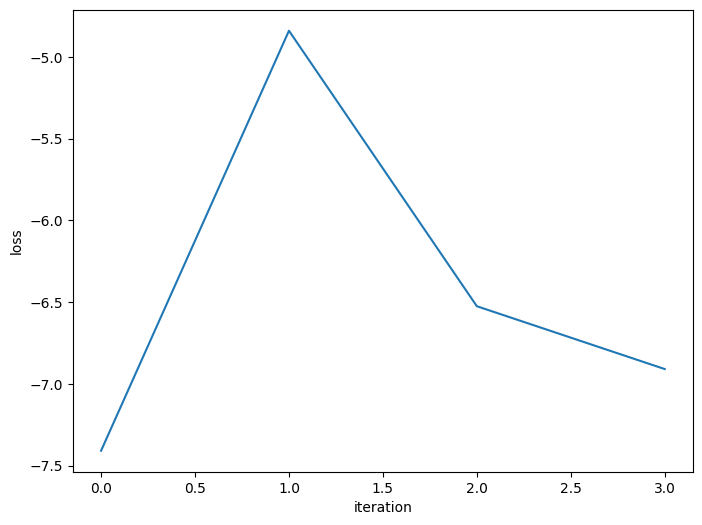

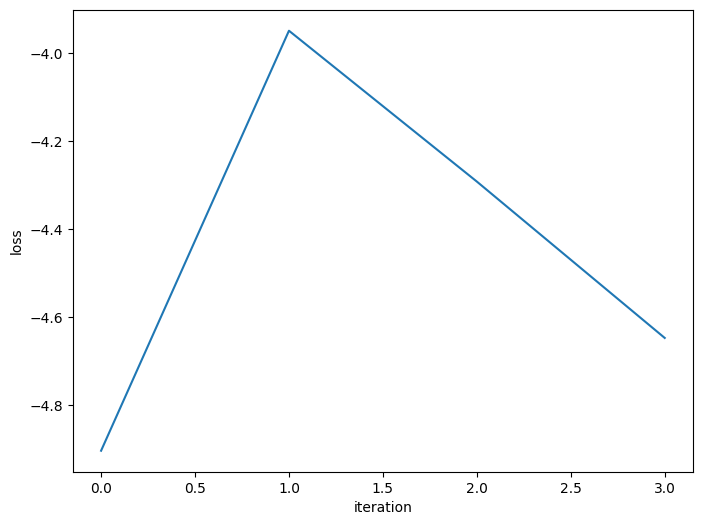

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -920.63617  validloss -902.84595±0.00000  bestvalidloss -902.84595  last_update 0
train: iter 1  trainloss -886.99931  validloss -871.48266±0.00000  bestvalidloss -902.84595  last_update 1
train: iter 2  trainloss -926.53833  validloss -849.19674±0.00000  bestvalidloss -902.84595  last_update 2
train: iter 3  trainloss -926.99950  validloss -896.37898±0.00000  bestvalidloss -902.84595  last_update 3
train: iter 4  trainloss -927.18798  validloss -904.63043±0.00000  bestvalidloss -904.63043  last_update 0
train: iter 5  trainloss -889.84805  validloss -780.25197±0.00000  bestvalidloss -904.63043  last_update 1
train: iter 6  trainloss -912.68225  validloss -884.39505±0.00000  bestvalidloss -904.63043  last_update 2
train: iter 7  trainloss -927.43404  validloss -833.26815±0.00000  bestvalidloss -904.63043  last_update 3
train: iter 8  trainloss -923.75282  validloss -865.94745±0.00000  bestvalidloss -904.63043  last_u

train: iter 76  trainloss -825.23899  validloss -604.65809±0.00000  bestvalidloss -908.64643  last_update 38
train: iter 77  trainloss -902.92359  validloss -836.11854±0.00000  bestvalidloss -908.64643  last_update 39
train: iter 78  trainloss -911.33770  validloss -854.20121±0.00000  bestvalidloss -908.64643  last_update 40
train: iter 79  trainloss -923.60043  validloss -840.47034±0.00000  bestvalidloss -908.64643  last_update 41
train: iter 80  trainloss -900.59654  validloss -886.34244±0.00000  bestvalidloss -908.64643  last_update 42
train: iter 81  trainloss -915.13870  validloss -816.88918±0.00000  bestvalidloss -908.64643  last_update 43
train: iter 82  trainloss -916.34133  validloss -859.94268±0.00000  bestvalidloss -908.64643  last_update 44
train: iter 83  trainloss -932.78814  validloss -884.15110±0.00000  bestvalidloss -908.64643  last_update 45
train: iter 84  trainloss -910.49865  validloss -846.35621±0.00000  bestvalidloss -908.64643  last_update 46
train: iter 85  tra

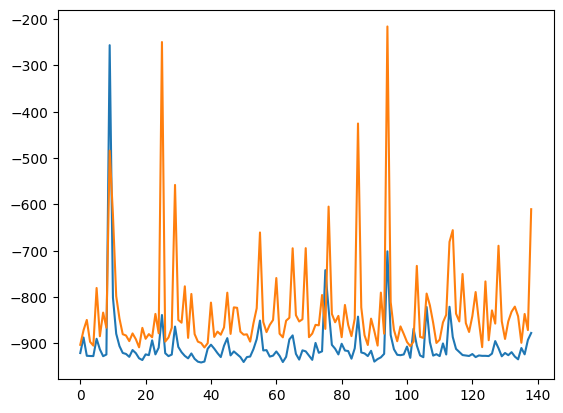

alpha 0.1 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-07-29 13:16:03.474866


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.52622  validloss 0.53046±0.00000  bestvalidloss 0.53046  last_update 0
train: iter 1  trainloss 0.51270  validloss 0.51709±0.00000  bestvalidloss 0.51709  last_update 0
train: iter 2  trainloss 0.50118  validloss 0.51584±0.00000  bestvalidloss 0.51584  last_update 0
train: iter 3  trainloss 0.49708  validloss 0.52582±0.00000  bestvalidloss 0.51584  last_update 1
train: iter 4  trainloss 0.49771  validloss 0.50663±0.00000  bestvalidloss 0.50663  last_update 0
train: iter 5  trainloss 0.48962  validloss 0.50614±0.00000  bestvalidloss 0.50614  last_update 0
train: iter 6  trainloss 0.48629  validloss 0.50670±0.00000  bestvalidloss 0.50614  last_update 1
train: iter 7  trainloss 0.48826  validloss 0.51190±0.00000  bestvalidloss 0.50614  last_update 2
train: iter 8  trainloss 0.48629  validloss 0.51881±0.00000  bestvalidloss 0.50614  last_update 3
train: iter 9  trainloss 0.48147  validloss 0.51669±0.00000  bestvalidloss 0.50614  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.45302  validloss 0.49757±0.00000  bestvalidloss 0.49207  last_update 11
train: iter 84  trainloss 0.45060  validloss 0.50158±0.00000  bestvalidloss 0.49207  last_update 12
train: iter 85  trainloss 0.45275  validloss 0.49541±0.00000  bestvalidloss 0.49207  last_update 13
train: iter 86  trainloss 0.45122  validloss 0.50337±0.00000  bestvalidloss 0.49207  last_update 14
train: iter 87  trainloss 0.45354  validloss 0.50376±0.00000  bestvalidloss 0.49207  last_update 15
train: iter 88  trainloss 0.45172  validloss 0.50028±0.00000  bestvalidloss 0.49207  last_update 16
train: iter 89  trainloss 0.45062  validloss 0.50243±0.00000  bestvalidloss 0.49207  last_update 17
train: iter 90  trainloss 0.44856  validloss 0.49443±0.00000  bestvalidloss 0.49207  last_update 18
train: iter 91  trainloss 0.44982  validloss 0.51578±0.00000  bestvalidloss 0.49207  last_update 19
train: iter 92  trainloss 0.44730  validloss 0.49440±0.00000  bestvalidloss 0.49207  last_update 20


train: iter 165  trainloss 0.43366  validloss 0.49504±0.00000  bestvalidloss 0.49029  last_update 70
train: iter 166  trainloss 0.43336  validloss 0.50438±0.00000  bestvalidloss 0.49029  last_update 71
train: iter 167  trainloss 0.44004  validloss 0.53618±0.00000  bestvalidloss 0.49029  last_update 72
train: iter 168  trainloss 0.43458  validloss 0.49829±0.00000  bestvalidloss 0.49029  last_update 73
train: iter 169  trainloss 0.44044  validloss 0.49972±0.00000  bestvalidloss 0.49029  last_update 74
train: iter 170  trainloss 0.43387  validloss 0.50362±0.00000  bestvalidloss 0.49029  last_update 75
train: iter 171  trainloss 0.43459  validloss 0.50306±0.00000  bestvalidloss 0.49029  last_update 76
train: iter 172  trainloss 0.43841  validloss 0.49639±0.00000  bestvalidloss 0.49029  last_update 77
train: iter 173  trainloss 0.43980  validloss 0.49745±0.00000  bestvalidloss 0.49029  last_update 78
train: iter 174  trainloss 0.43340  validloss 0.50044±0.00000  bestvalidloss 0.49029  last_

train_loss:  -8.758954612150786
valid_loss:  -9.475293730556967
weight_alpha 1.0 h_min_tilde -11.514865 ell_tilde -8.902222435832023 kappa_tilde 0.0006186713539534007
train_loss:  -4.818450618457794
valid_loss:  -4.2516719514846795
weight_alpha 0.1 h_min_tilde -11.514865 ell_tilde -4.705094885063171 kappa_tilde 0.00038320730284243477


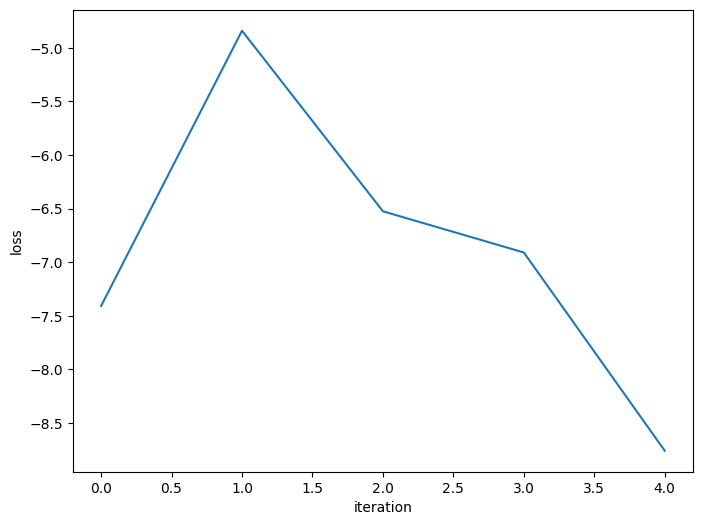

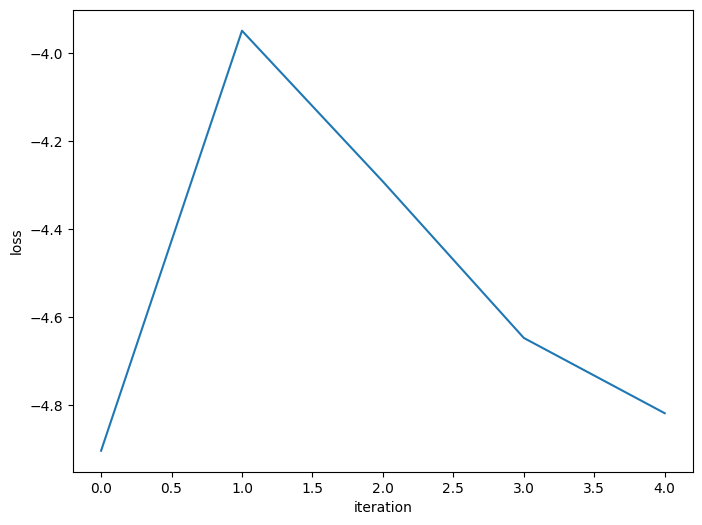

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -971.23635  validloss -843.82151±0.00000  bestvalidloss -843.82151  last_update 0
train: iter 1  trainloss -967.59744  validloss -889.03292±0.00000  bestvalidloss -889.03292  last_update 0
train: iter 2  trainloss -955.38519  validloss -877.45652±0.00000  bestvalidloss -889.03292  last_update 1
train: iter 3  trainloss -937.50524  validloss -833.79527±0.00000  bestvalidloss -889.03292  last_update 2
train: iter 4  trainloss -968.07308  validloss -875.72194±0.00000  bestvalidloss -889.03292  last_update 3
train: iter 5  trainloss -985.39429  validloss -879.07141±0.00000  bestvalidloss -889.03292  last_update 4
train: iter 6  trainloss -951.88594  validloss -914.38240±0.00000  bestvalidloss -914.38240  last_update 0
train: iter 7  trainloss -953.49014  validloss -640.34324±0.00000  bestvalidloss -914.38240  last_update 1
train: iter 8  trainloss -983.80146  validloss -897.21988±0.00000  bestvalidloss -914.38240  last_u

train: iter 76  trainloss -959.63106  validloss -827.18359±0.00000  bestvalidloss -929.14663  last_update 62
train: iter 77  trainloss -969.52548  validloss -854.68551±0.00000  bestvalidloss -929.14663  last_update 63
train: iter 78  trainloss -967.48205  validloss -883.01045±0.00000  bestvalidloss -929.14663  last_update 64
train: iter 79  trainloss -960.10937  validloss -875.37231±0.00000  bestvalidloss -929.14663  last_update 65
train: iter 80  trainloss -969.42984  validloss -828.37104±0.00000  bestvalidloss -929.14663  last_update 66
train: iter 81  trainloss -967.74553  validloss -879.91535±0.00000  bestvalidloss -929.14663  last_update 67
train: iter 82  trainloss -758.52077  validloss -535.91565±0.00000  bestvalidloss -929.14663  last_update 68
train: iter 83  trainloss -948.55930  validloss -833.59775±0.00000  bestvalidloss -929.14663  last_update 69
train: iter 84  trainloss -946.90621  validloss -855.43815±0.00000  bestvalidloss -929.14663  last_update 70
train: iter 85  tra

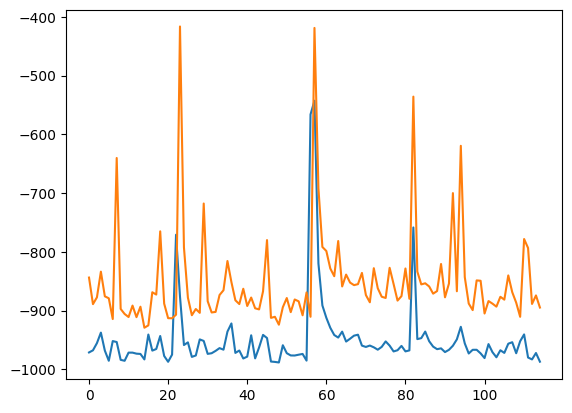

alpha 0.1 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-07-29 13:39:25.095551


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77
predict diverge [ 30.88427607  24.47340446   1.90373721 -17.91234909] [ 0.94652222  1.04032166 -0.90806036  1.16637109] [146.79016   23.436619 198.34738   31.218063] [73.39508  11.718309 99.17369  15.609032] sim_timestep 186

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.53818  validloss 0.66142±0.00000  bestvalidloss 0.66142  last_update 0
train: iter 1  trainloss 0.52666  validloss 0.64119±0.00000  bestvalidloss 0.64119  last_update 0
train: iter 2  trainloss 0.51445  validloss 0.61472±0.00000  bestvalidloss 0.61472  last_update 0
train: iter 3  trainloss 0.51175  validloss 0.63400±0.00000  bestvalidloss 0.61472  last_update 1
train: iter 4  trainloss 0.50130  validloss 0.62742±0.00000  bestvalidloss 0.61472  last_update 2
train: iter 5  trainloss 0.49848  validloss 0.62254±0.00000  bestvalidloss 0.61472  last_update 3
train: iter 6  trainloss 0.49613  validloss 0.62429±0.00000  bestvalidloss 0.61472  last_update 4
train: iter 7  trainloss 0.49128  validloss 0.62770±0.00000  bestvalidloss 0.61472  last_update 5
train: iter 8  trainloss 0.49024  validloss 0.62628±0.00000  bestvalidloss 0.61472  last_update 6
train: iter 9  trainloss 0.48595  validloss 0.61143±0.00000  bestvalidloss 0.61143  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.45197  validloss 0.59613±0.00000  bestvalidloss 0.57015  last_update 16
train: iter 84  trainloss 0.44882  validloss 0.58690±0.00000  bestvalidloss 0.57015  last_update 17
train: iter 85  trainloss 0.44939  validloss 0.59411±0.00000  bestvalidloss 0.57015  last_update 18
train: iter 86  trainloss 0.45089  validloss 0.59840±0.00000  bestvalidloss 0.57015  last_update 19
train: iter 87  trainloss 0.44953  validloss 0.60206±0.00000  bestvalidloss 0.57015  last_update 20
train: iter 88  trainloss 0.44987  validloss 0.58068±0.00000  bestvalidloss 0.57015  last_update 21
train: iter 89  trainloss 0.44977  validloss 0.59730±0.00000  bestvalidloss 0.57015  last_update 22
train: iter 90  trainloss 0.44677  validloss 0.59136±0.00000  bestvalidloss 0.57015  last_update 23
train: iter 91  trainloss 0.44983  validloss 0.59228±0.00000  bestvalidloss 0.57015  last_update 24
train: iter 92  trainloss 0.44694  validloss 0.59717±0.00000  bestvalidloss 0.57015  last_update 25


train: iter 165  trainloss 0.44075  validloss 0.59597±0.00000  bestvalidloss 0.57015  last_update 98
train: iter 166  trainloss 0.43563  validloss 0.59448±0.00000  bestvalidloss 0.57015  last_update 99
train: iter 167  trainloss 0.43688  validloss 0.61943±0.00000  bestvalidloss 0.57015  last_update 100
train: fin


([0.5381783358752728,
  0.5266634121537208,
  0.5144495749846101,
  0.5117498798295855,
  0.5012961160391569,
  0.4984806409105659,
  0.49612866099923847,
  0.491281196847558,
  0.4902374740689993,
  0.48595281038433313,
  0.4849990287795663,
  0.47853942289948465,
  0.4781478848308325,
  0.47752652037888765,
  0.47941681928932667,
  0.484008021466434,
  0.47809524461627007,
  0.4796970134600997,
  0.4762591876089573,
  0.47611195370554926,
  0.4727867767214775,
  0.4728630380704999,
  0.46998134180903434,
  0.4725168712437153,
  0.47725071795284746,
  0.46628927122801545,
  0.47401808500289916,
  0.46851060185581445,
  0.466011262871325,
  0.46773550771176814,
  0.46552380416542294,
  0.465768008120358,
  0.46329821925610304,
  0.4727308010682464,
  0.4720833286643028,
  0.4663542419672012,
  0.46190167050808667,
  0.46223240755498407,
  0.46216890327632426,
  0.46208669263869523,
  0.46768169160932305,
  0.46021099854260683,
  0.46632081605494025,
  0.46023425105959176,
  0.462260174

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.041396780362724
valid_loss:  -7.876379098737239
weight_alpha 1.0 h_min_tilde -11.541971 ell_tilde -6.408393244037627 kappa_tilde 0.00044135689843352295
train_loss:  -4.761751207816601
valid_loss:  -4.322450037097931
weight_alpha 0.1 h_min_tilde -11.541971 ell_tilde -4.673890973672867 kappa_tilde 0.0003815771149324143


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 83.17038  validloss 99.94265±0.00000  bestvalidloss 99.94265  last_update 0
train: iter 1  trainloss 66.05333  validloss 78.48308±0.00000  bestvalidloss 78.48308  last_update 0
train: iter 2  trainloss 52.24358  validloss 62.26526±0.00000  bestvalidloss 62.26526  last_update 0
train: iter 3  trainloss 41.72237  validloss 49.31981±0.00000  bestvalidloss 49.31981  last_update 0
train: iter 4  trainloss 34.02803  validloss 38.95432±0.00000  bestvalidloss 38.95432  last_update 0
train: iter 5  trainloss 27.74068  validloss 31.76279±0.00000  bestvalidloss 31.76279  last_update 0
train: iter 6  trainloss 22.76325  validloss 26.22343±0.00000  bestvalidloss 26.22343  last_update 0
train: iter 7  trainloss 19.24200  validloss 20.80542±0.00000  bestvalidloss 20.80542  last_update 0
train: iter 8  trainloss 16.29409  validloss 17.54201±0.00000  bestvalidloss 17.54201  last_update 0
train: iter 9  trainloss 14.12657  validloss 14.84176±0.00000  bestvalidloss 14.84176  last

train: iter 98  trainloss 0.42703  validloss 0.16343±0.00000  bestvalidloss 0.16343  last_update 0
train: iter 99  trainloss 0.44346  validloss 0.18563±0.00000  bestvalidloss 0.16343  last_update 1
train: iter 100  trainloss 0.44082  validloss 0.24618±0.00000  bestvalidloss 0.16343  last_update 2
train: iter 101  trainloss 0.39399  validloss 0.16713±0.00000  bestvalidloss 0.16343  last_update 3
train: iter 102  trainloss 0.40599  validloss 0.15208±0.00000  bestvalidloss 0.15208  last_update 0
train: iter 103  trainloss 0.38221  validloss 0.18165±0.00000  bestvalidloss 0.15208  last_update 1
train: iter 104  trainloss 0.40743  validloss 0.18892±0.00000  bestvalidloss 0.15208  last_update 2
train: iter 105  trainloss 0.36945  validloss 0.16942±0.00000  bestvalidloss 0.15208  last_update 3
train: iter 106  trainloss 0.38531  validloss 0.12739±0.00000  bestvalidloss 0.12739  last_update 0
train: iter 107  trainloss 0.37269  validloss 0.14430±0.00000  bestvalidloss 0.12739  last_update 1
tr

train: iter 193  trainloss 0.23910  validloss 0.09225±0.00000  bestvalidloss 0.06544  last_update 52
train: iter 194  trainloss 0.26301  validloss 0.12972±0.00000  bestvalidloss 0.06544  last_update 53
train: iter 195  trainloss 0.26280  validloss 0.12697±0.00000  bestvalidloss 0.06544  last_update 54
train: iter 196  trainloss 0.28049  validloss 0.07783±0.00000  bestvalidloss 0.06544  last_update 55
train: iter 197  trainloss 0.25481  validloss 0.07411±0.00000  bestvalidloss 0.06544  last_update 56
train: iter 198  trainloss 0.26078  validloss 0.06836±0.00000  bestvalidloss 0.06544  last_update 57
train: iter 199  trainloss 0.26049  validloss 0.14362±0.00000  bestvalidloss 0.06544  last_update 58
train: iter 200  trainloss 0.25308  validloss 0.11319±0.00000  bestvalidloss 0.06544  last_update 59
train: iter 201  trainloss 0.27655  validloss 0.11930±0.00000  bestvalidloss 0.06544  last_update 60
train: iter 202  trainloss 0.26517  validloss 0.13819±0.00000  bestvalidloss 0.06544  last_

train: iter 276  trainloss 0.23551  validloss 0.11532±0.00000  bestvalidloss 0.05930  last_update 43
train: iter 277  trainloss 0.25823  validloss 0.11494±0.00000  bestvalidloss 0.05930  last_update 44
train: iter 278  trainloss 0.25773  validloss 0.10101±0.00000  bestvalidloss 0.05930  last_update 45
train: iter 279  trainloss 0.25310  validloss 0.12353±0.00000  bestvalidloss 0.05930  last_update 46
train: iter 280  trainloss 0.24235  validloss 0.14321±0.00000  bestvalidloss 0.05930  last_update 47
train: iter 281  trainloss 0.25995  validloss 0.11949±0.00000  bestvalidloss 0.05930  last_update 48
train: iter 282  trainloss 0.27325  validloss 0.10812±0.00000  bestvalidloss 0.05930  last_update 49
train: iter 283  trainloss 0.26121  validloss 0.11376±0.00000  bestvalidloss 0.05930  last_update 50
train: iter 284  trainloss 0.26710  validloss 0.12132±0.00000  bestvalidloss 0.05930  last_update 51
train: iter 285  trainloss 0.24651  validloss 0.12124±0.00000  bestvalidloss 0.05930  last_

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([ 0.9282, -1.8384, -2.3071, -2.8411], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 8.23181  validloss 26.38203±0.00000  bestvalidloss 26.38203  last_update 0
train: iter 1  trainloss 8.12367  validloss 26.85055±0.00000  bestvalidloss 26.38203  last_update 1
train: iter 2  trainloss 7.78163  validloss 28.33525±0.00000  bestvalidloss 26.38203  last_update 2
train: iter 3  trainloss 7.94626  validloss 26.86981±0.00000  bestvalidloss 26.38203  last_update 3
train: iter 4  trainloss 7.75071  validloss 28.17503±0.00000  bestvalidloss 26.38203  last_update 4
train: iter 5  trainloss 7.71522  validloss 27.24505±0.00000  bestvalidloss 26.38203  last_update 5
train: iter 6  trainloss 7.61679  validloss 27.11502±0.00000  bestvalidloss 26.38203  last_update 6
train: iter 7  trainloss 7.76388  validloss 28.43378±0.00000  bestvalidloss 26.38203  last_update 7
train: iter 8  trainloss 7.77203  validloss 28.61857±0.00000  bestvalidloss 26.38203  last_update 8
train: iter 9  trainloss 8.03140  validloss 26.17529±0.00000  bestvalidloss 26.17529  last_update 0


train: iter 81  trainloss 7.44898  validloss 29.46847±0.00000  bestvalidloss 24.50775  last_update 54
train: iter 82  trainloss 7.44400  validloss 27.79351±0.00000  bestvalidloss 24.50775  last_update 55
train: iter 83  trainloss 7.53180  validloss 27.48837±0.00000  bestvalidloss 24.50775  last_update 56
train: iter 84  trainloss 7.53681  validloss 27.95822±0.00000  bestvalidloss 24.50775  last_update 57
train: iter 85  trainloss 7.62037  validloss 26.52350±0.00000  bestvalidloss 24.50775  last_update 58
train: iter 86  trainloss 7.52321  validloss 25.10948±0.00000  bestvalidloss 24.50775  last_update 59
train: iter 87  trainloss 7.42128  validloss 27.53570±0.00000  bestvalidloss 24.50775  last_update 60
train: iter 88  trainloss 7.47294  validloss 26.41194±0.00000  bestvalidloss 24.50775  last_update 61
train: iter 89  trainloss 7.71582  validloss 26.45003±0.00000  bestvalidloss 24.50775  last_update 62
train: iter 90  trainloss 7.44278  validloss 29.68918±0.00000  bestvalidloss 24.50

In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-6.0585)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(2.0382)


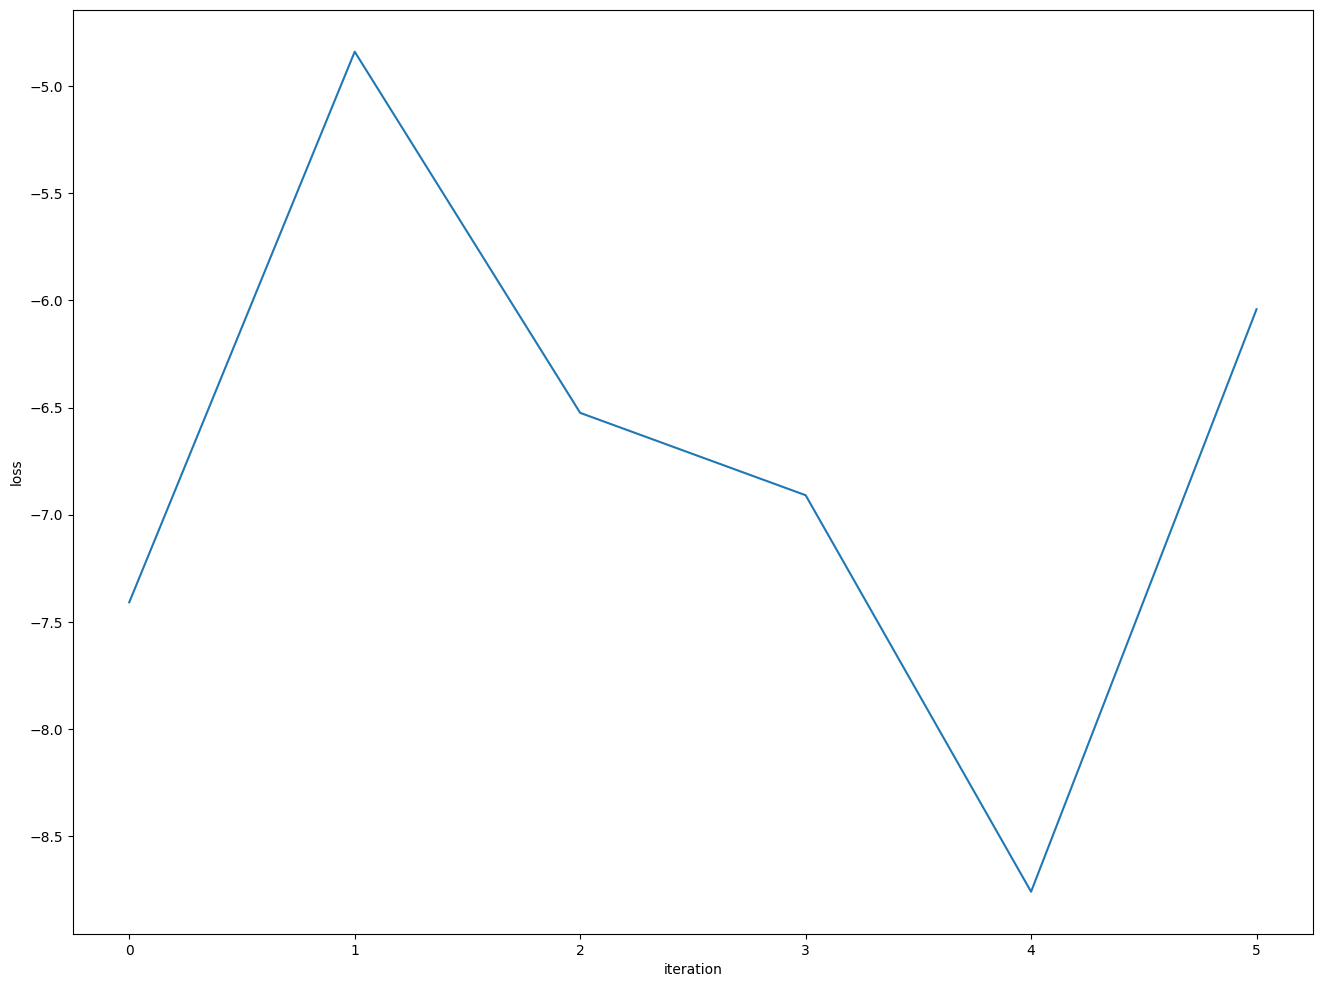

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

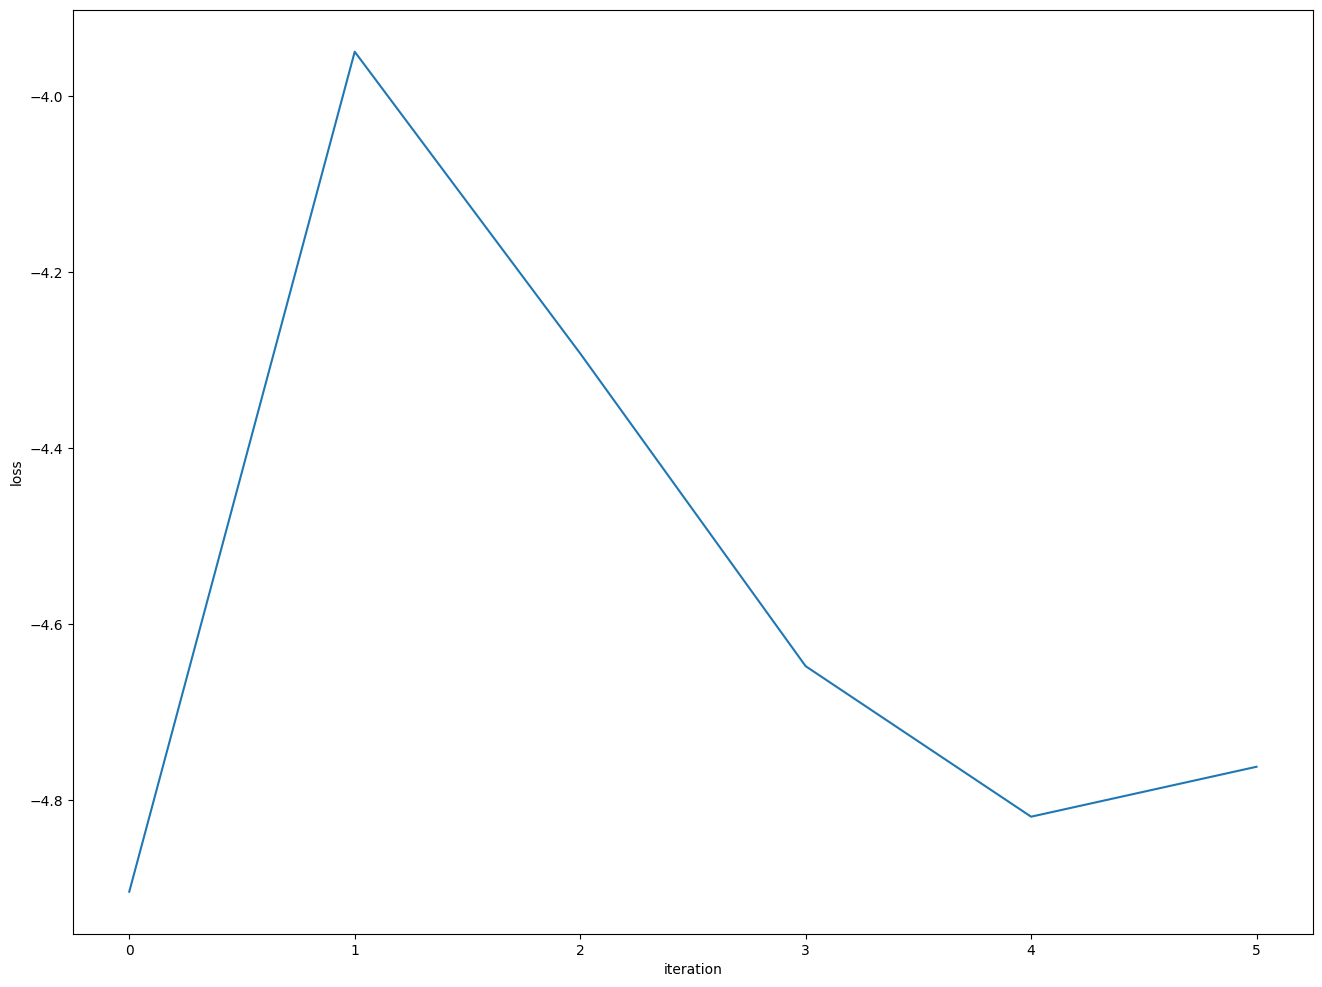

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")